In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema

In [102]:
plt.style.use('ggplot')

In [103]:
# path = '/Users/testing/Documents/Udemy Strategies/Strategy 9 - Peak levels'

In [104]:
pairs_list = [
    'EURUSD/EURUSD_H4 - EURUSD_H4',
    'AUDUSD/AUDUSD_H4 - AUDUSD_H4',
    'GBPUSD/GBPUSD_H4 - GBPUSD_H4',
    'NZDUSD/NZDUSD_H4 - NZDUSD_H4',
    'USDCAD/USDCAD_H4 - USDCAD_H4',
    'USDCHF/USDCHF_H4 - USDCHF_H4',
    'USDJPY/USDJPY_H4 - USDJPY_H4',
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]

In [105]:
# pairs_list = []
# for filename in os.listdir(path):
#     if filename.endswith('.csv'):
#         pairs_list.append(filename.split('.')[0])
# print(pairs_list)

# df = {}
# for pair in range(len(pairs_list)):
#     df[pair] = pd.read_csv(pairs_list[pair]+'.csv', header = 0)
#     df[pair].columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
#     df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
#     df[pair]['Date'] = df[pair]['Date'].str.join(' ')
#     df[pair].set_index('Date', inplace = True)
#     df[pair].index = pd.to_datetime(df[pair].index, format = '%d.%m.%Y %H:%M:%S.%f')
#     df[pair]['Day'] = df[pair].index.dayofweek
#     dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
#     df[pair]['Day'] = df[pair]['Day'].map(dmap)
#     df[pair]['min'] = ''
#     df[pair]['max'] = ''

In [106]:
df ={}
for pair in range(len(pairs_list)) :
    df[pair] = pd.read_csv('../../Data_Forex/'+pairs_list[pair]+'.csv',index_col=0,parse_dates=True)
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = None
    df[pair]['max'] = None

In [107]:
df[0]

,Open,High,Low,Close,Volume,Day,min,max
Time,,,,,,,,
2007-03-05 12:00:00,1.30956,1.31145,1.30723,1.30979,185987,Mon,None,None
2007-03-05 16:00:00,1.30960,1.31112,1.30833,1.30981,1025327,Mon,None,None
2007-03-05 20:00:00,1.30979,1.30986,1.30782,1.30840,235967,Mon,None,None
2007-03-06 00:00:00,1.30813,1.31113,1.30798,1.31071,191415,Tue,None,None
2007-03-06 04:00:00,1.31078,1.31262,1.30923,1.31211,187099,Tue,None,None
...,...,...,...,...,...,...,...,...
2023-03-10 00:00:00,1.05855,1.05993,1.05791,1.05967,62976,Fri,None,None
2023-03-10 04:00:00,1.05967,1.06066,1.05809,1.05948,58412,Fri,None,None
2023-03-10 08:00:00,1.05946,1.06036,1.05738,1.05894,86765,Fri,None,None


In [108]:
#Strategy parameters
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5

plot_trades = False

In [109]:
def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [110]:


for pair in range(len(pairs_list)):
    price = df[pair]['Close']
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']

    minima_indices = argrelextrema(price.values, np.less_equal, order=100)[0]
    maxima_indices = argrelextrema(price.values, np.greater_equal, order=100)[0]

    df[pair].loc[df[pair].index[minima_indices], 'min'] = price.iloc[minima_indices]


    df[pair].loc[df[pair].index[maxima_indices], 'max'] = price.iloc[maxima_indices]

    # df[pair]['min'] = df[pair]['min'].iloc[argrelextrema(price.values, np.less_equal, order = 100)[-1]]
    # df[pair]['max'] = df[pair]['max'].iloc[argrelextrema(price.values, np.greater_equal, order = 100)[-1]]
    if 'JPY' not in pairs_list[pair]:
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  EURUSD/EURUSD_H4 - EURUSD_H4 a
Pair:  AUDUSD/AUDUSD_H4 - AUDUSD_H4 a
Pair:  GBPUSD/GBPUSD_H4 - GBPUSD_H4 a
Pair:  NZDUSD/NZDUSD_H4 - NZDUSD_H4 a
Pair:  USDCAD/USDCAD_H4 - USDCAD_H4 a
Pair:  USDCHF/USDCHF_H4 - USDCHF_H4 a
Pair:  USDJPY/USDJPY_H4 - USDJPY_H4 b
Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 a


In [111]:
def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)
    
    plt.show()

In [112]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
support = {}
resist = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    support[pair] = []
    resist[pair] = []
    
    for i in range(50, len(df[pair])):
        if ( df[pair]['max'][i - 12] != None  and df[pair]['max'][i - 12] > 0):
            resist[pair].append(df[pair]['max'][i - 12])
        elif ( df[pair]['min'][i - 12] != None and df[pair]['min'][i - 12]) > 0:
            support[pair].append(df[pair]['min'][i - 12])
        #Buy
        if support[pair] != [] and any(df[pair]['Close'][i - 1] > s for s in support[pair]) and any(df[pair]['Close'][i] <= s for s in support[pair]) \
            and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            support[pair].remove(support[pair][-1])
        
        #Sell
        if resist[pair] != [] and any(df[pair]['Close'][i - 1] < r for r in resist[pair]) and any(df[pair]['Close'][i] >= r for r in resist[pair]) \
            and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            resist[pair].remove(resist[pair][-1])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy Trailing SL
        if any(y <= df[pair]['Close'][i] for y in long_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    #Move SL to BE
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + df[pair]['spread'][i]})
                        print(j, 
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_entry_price[pair] = []
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to second ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 3 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j, 
                             'Trailing SL to second ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
        #Sell Trailing SL
        if any(y >= df[pair]['Close'][i] for y in short_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    #Move SL to BE
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - df[pair]['spread'][i]})
                        print(j, 
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_entry_price[pair] = []
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 3 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j, 
                             'Trailing SL to second ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                        
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])

564 New Short trade at price: 1.3713  On day: 2007-07-10 12:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
564 Short loss at price: 1.3728 On day: 2007-07-10 16:00:00 With loss: -14.755 

845 New Short trade at price: 1.3837  On day: 2007-09-11 20:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
845 Short loss at price: 1.3884 On day: 2007-09-12 08:00:00 With loss: -17.235 

1588 New Short trade at price: 1.4965  On day: 2008-02-26 16:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
1588 Short loss at price: 1.4995 On day: 2008-02-26 20:00:00 With loss: -23.69 

1683 New Short trade at price: 1.5685  On day: 2008-03-19 00:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
1683 Moved SL to BE: 1.5683 On day: 2008-03-19 12:00:00 

1683 Short profit at price: 1.5445 On day: 2008-03-20 08:00:00 With profit: 203.9375 

1847 New Short trade at price: 1.5665  On day: 2008-04-24 12:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
1847 Moved SL to BE: 1.5663 On day: 2008-04-25 04:00:00 

1847 Trailing SL to first ATR: 1.5631 On day: 

In [113]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

C:\Users\Win10\AppData\Local\Temp\ipykernel_3912\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'entry_price_x', 'day_of_trade_x', 'cum_res_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_3912\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'entry_price_x', 'day_of_trade_x', 'cum_res_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_3912\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'entry_price_x', 'day_of_trade_x', 'cum_res_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())


Text(0.5, 1.0, 'Returns of each pair')

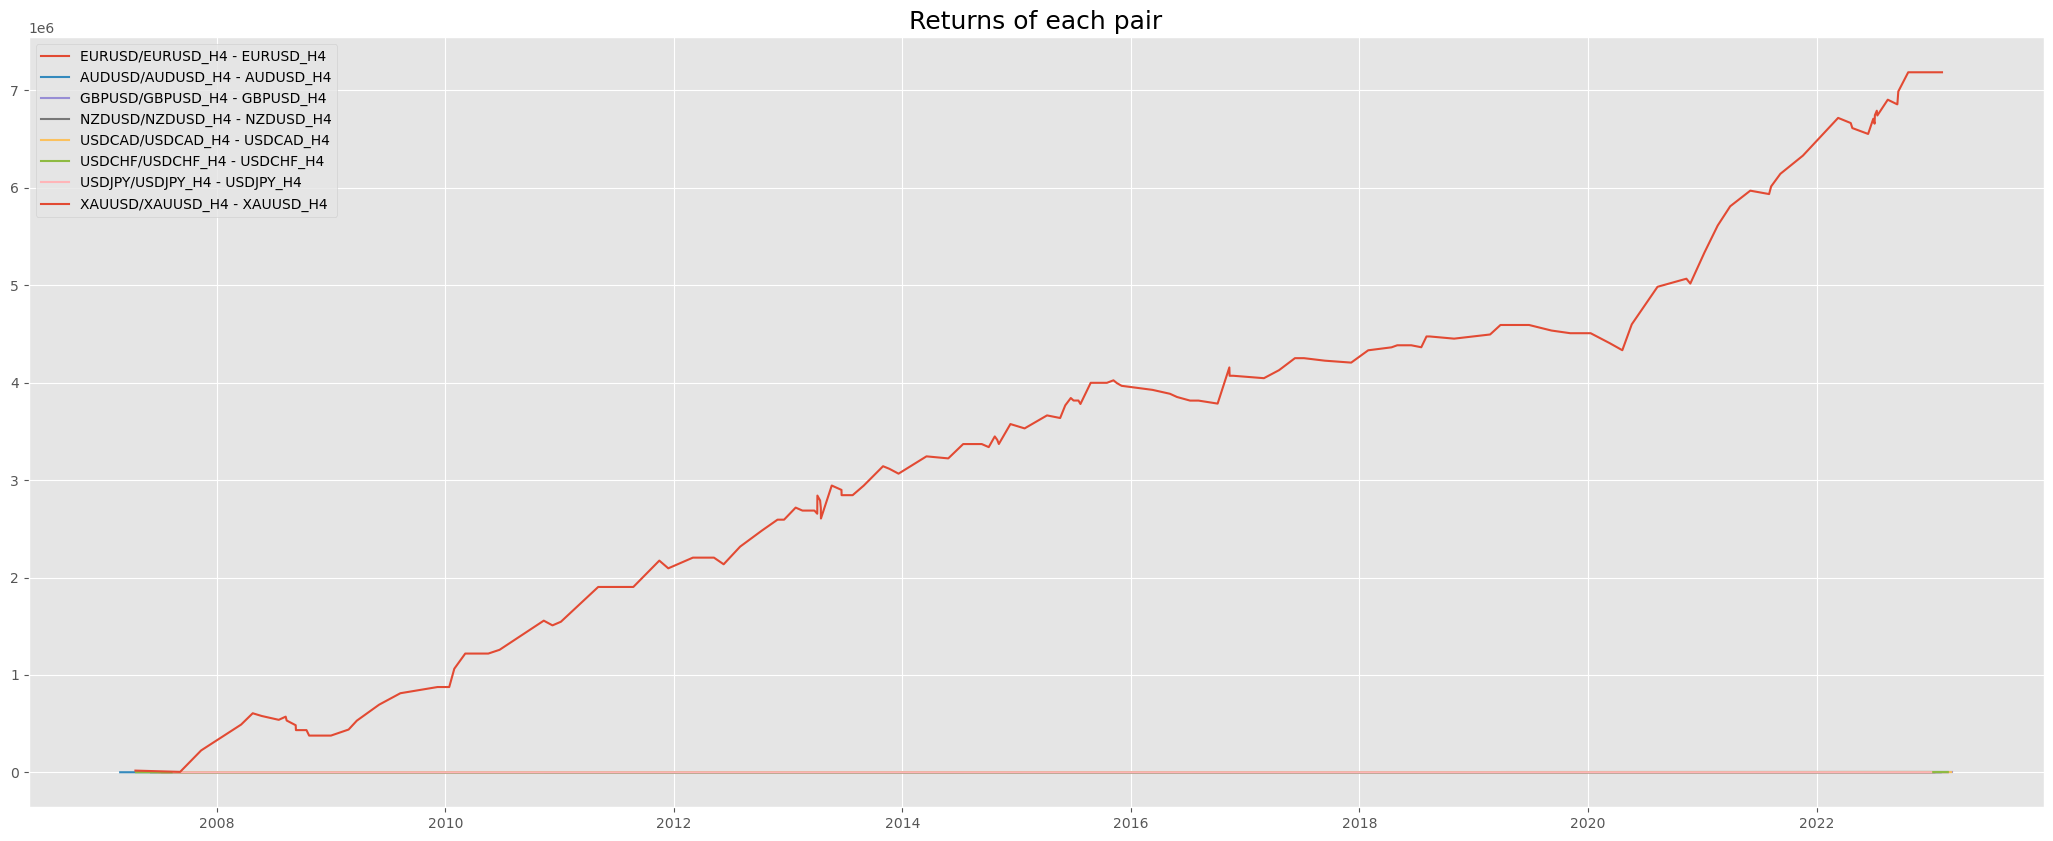

In [114]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 699.0 %
Sharpe ratio: 0.0
Maximum drawdown 73.19 % 

Number of trades: 1169
Number of profits: 370
Number of losses: 586
Number of breakevens: 213 

Winning percentage 38.7 %
ROI: 7194508
--------------------------------
Average profitable trade: 25690.95
Average lossing trade: -3943.93
Max profitable trade: 387598.0
Max lossing trade: -106929.0


c:\Users\Win10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Text(0.5, 1.0, 'return of strategy')

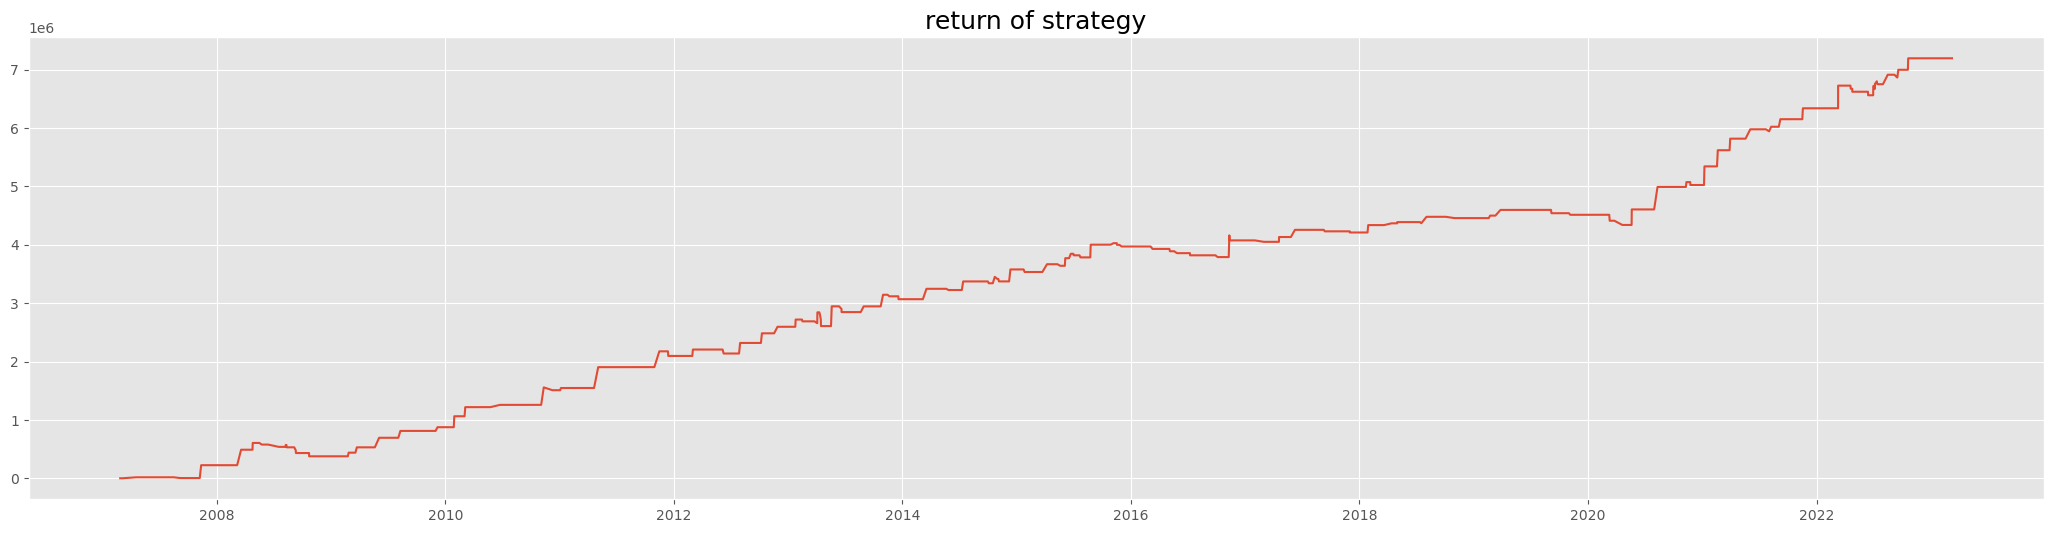

In [115]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)

EURUSD/EURUSD_H4 - EURUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 149
Number of profits: 37
Number of losses: 86
Number of breakevens: 26 

Winning percentage 30.08 %
ROI: 452.15
--------------------------------
Average profitable trade: 63.32
Average lossing trade: -21.98
Max profitable trade: 203.94
Max lossing trade: -51.41
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    27
Mon    15
Sun     3
Thu    39
Tue    29
Wed    36
Name: result, dtype: int64


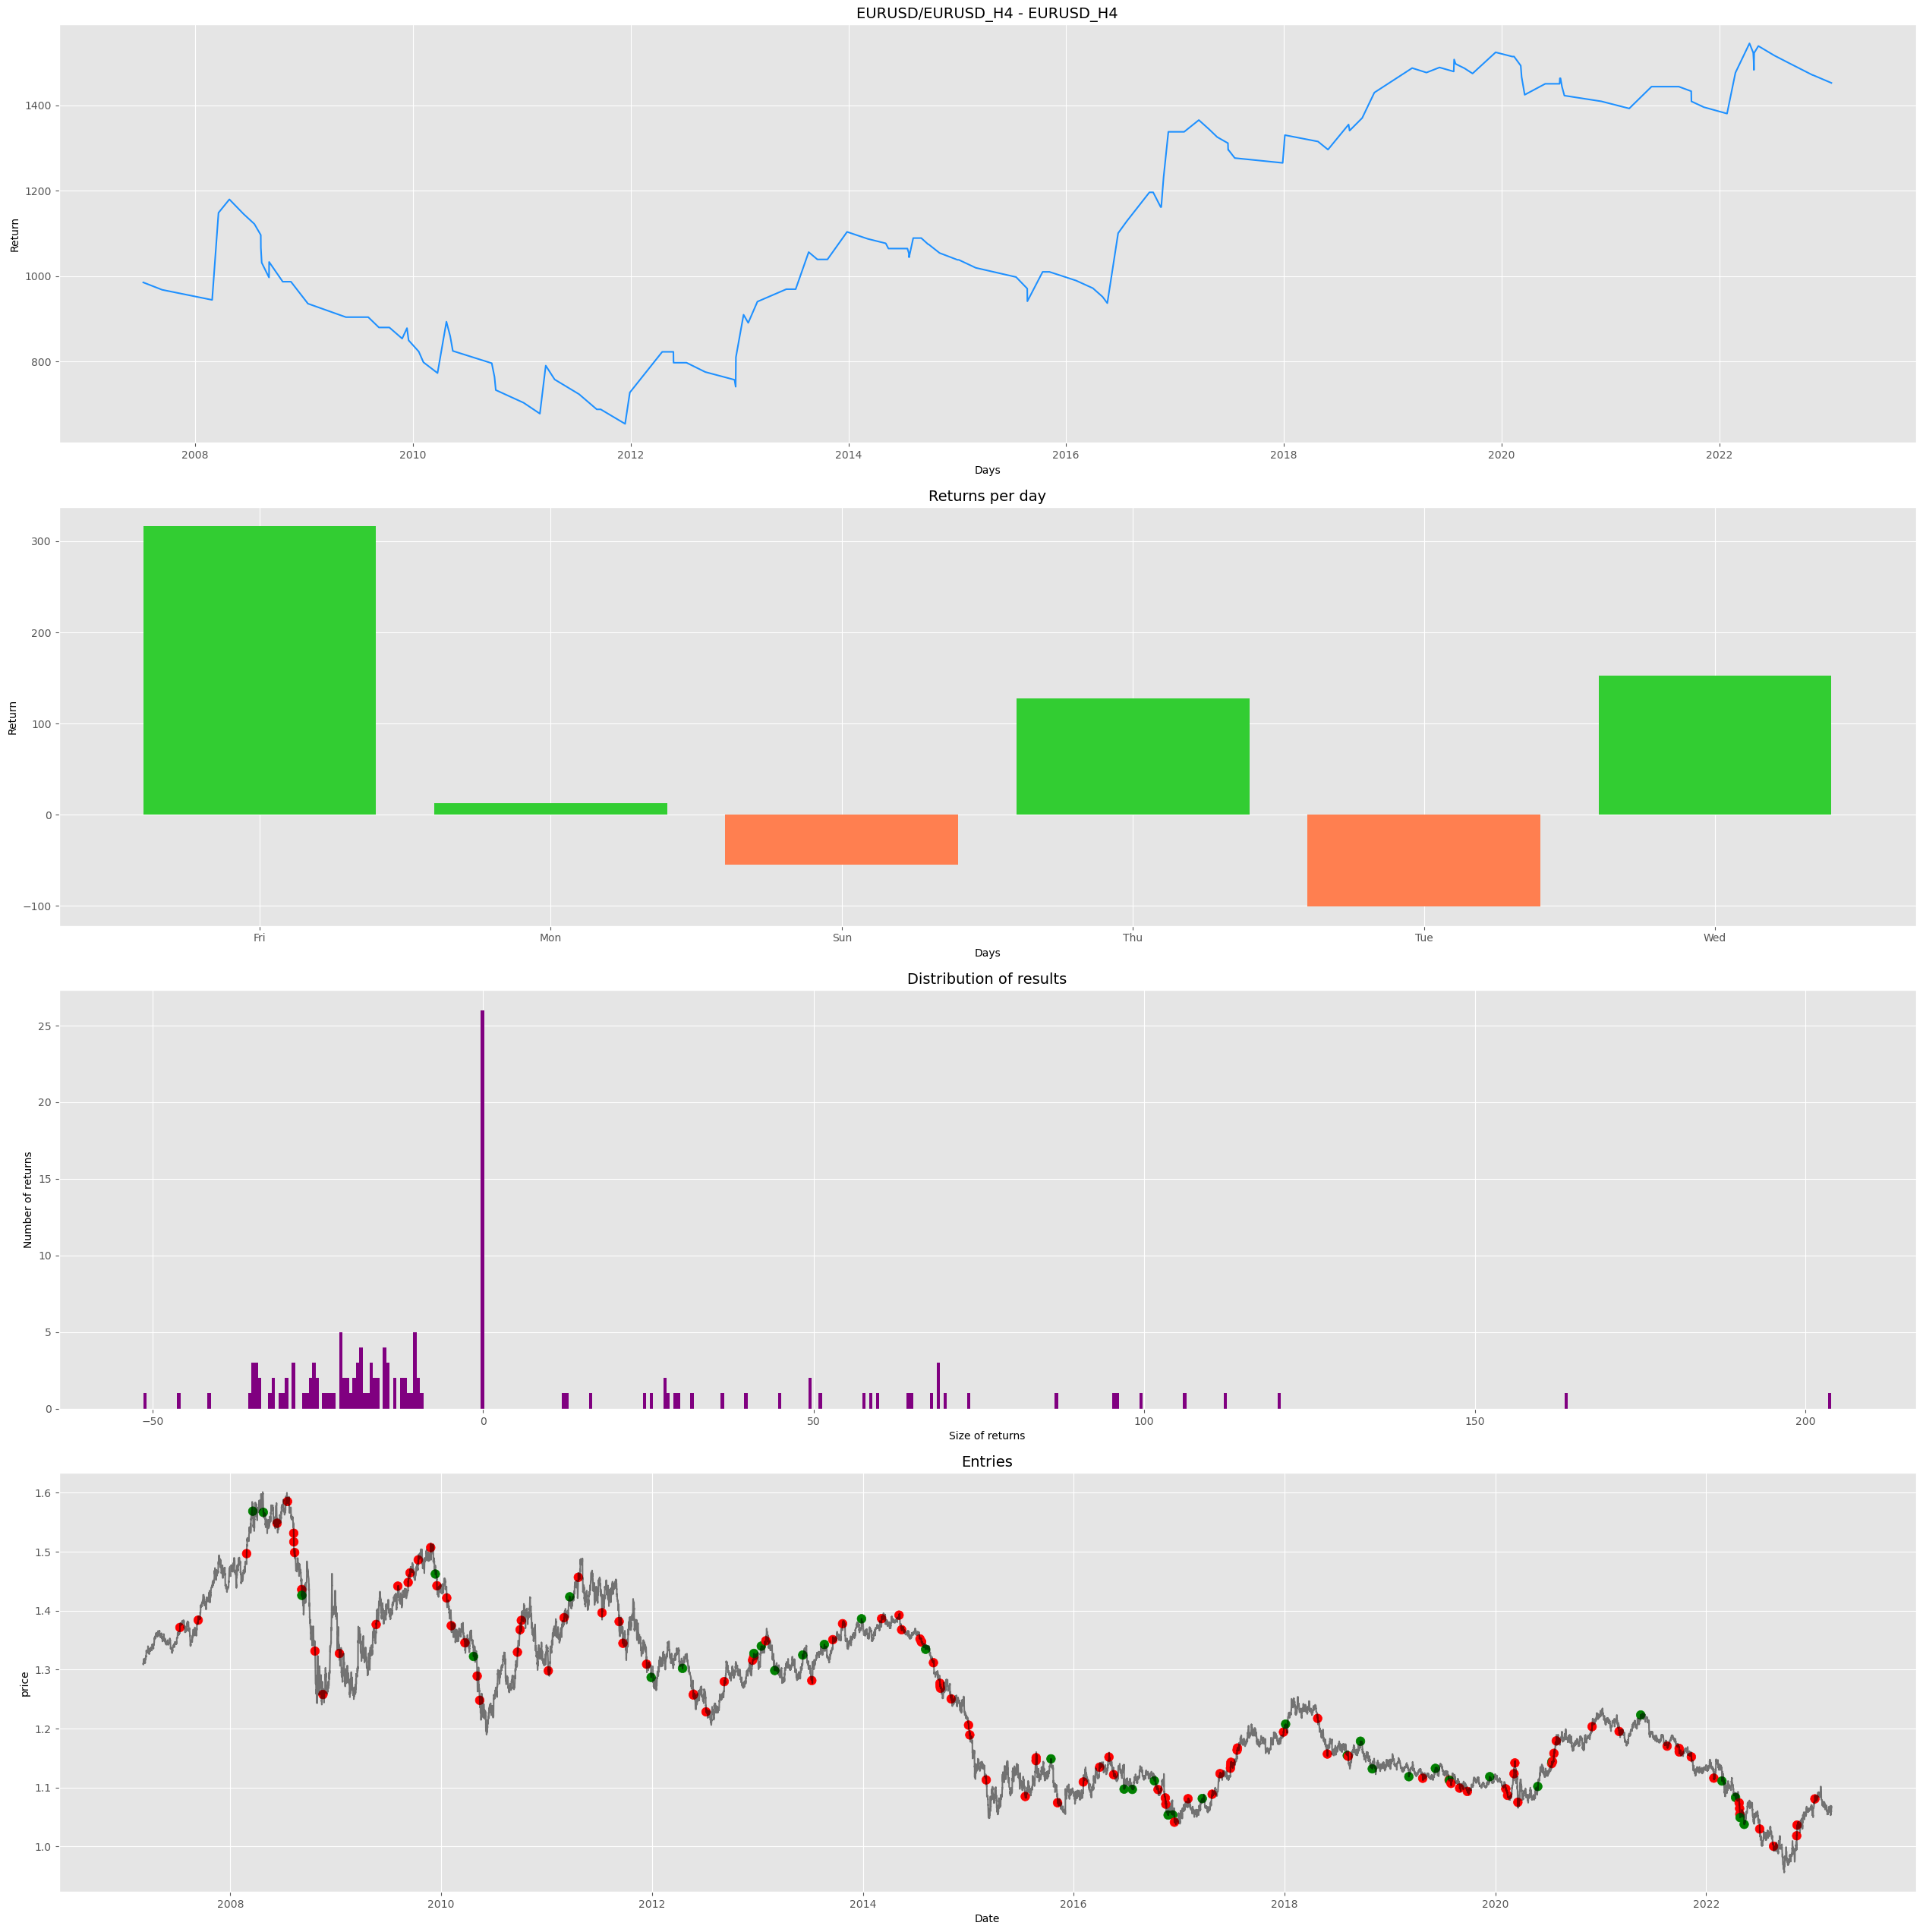

AUDUSD/AUDUSD_H4 - AUDUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 144
Number of profits: 41
Number of losses: 75
Number of breakevens: 28 

Winning percentage 35.34 %
ROI: 374.67
--------------------------------
Average profitable trade: 46.11
Average lossing trade: -20.21
Max profitable trade: 147.5
Max lossing trade: -52.24
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    33
Mon    17
Sun     2
Thu    36
Tue    28
Wed    28
Name: result, dtype: int64


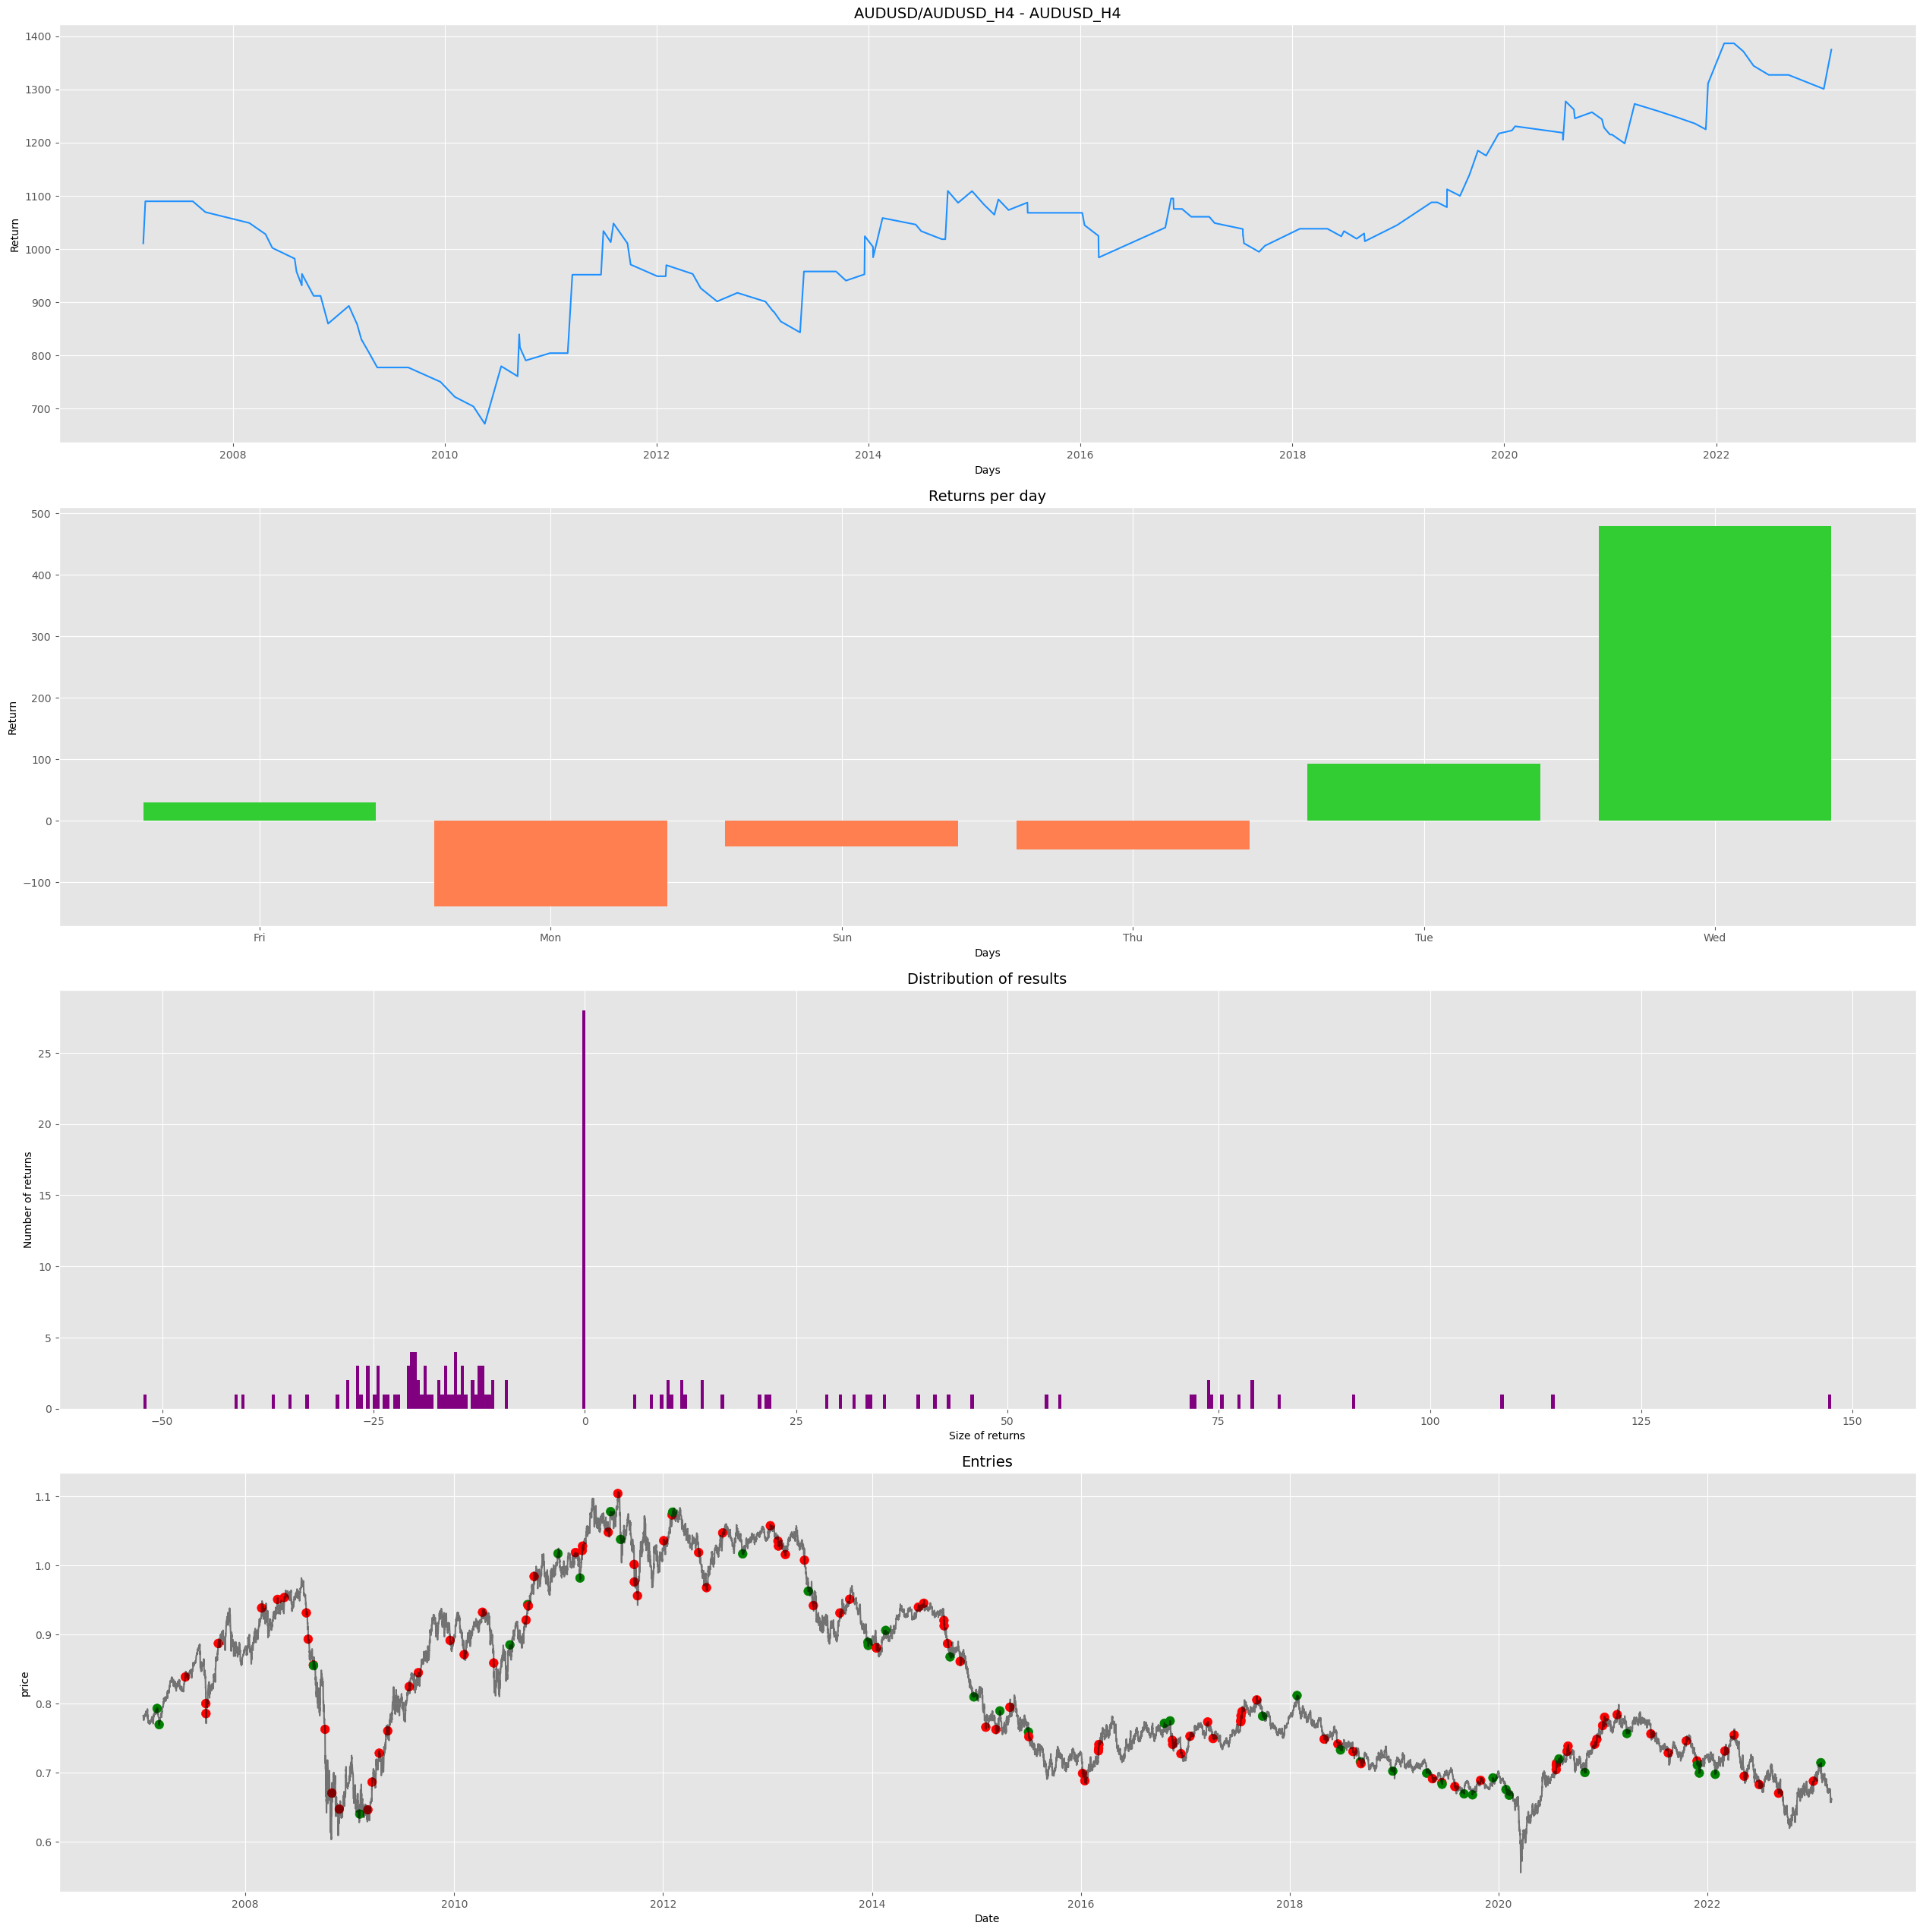

GBPUSD/GBPUSD_H4 - GBPUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 140
Number of profits: 49
Number of losses: 61
Number of breakevens: 30 

Winning percentage 44.55 %
ROI: 2849.78
--------------------------------
Average profitable trade: 91.91
Average lossing trade: -27.11
Max profitable trade: 317.85
Max lossing trade: -79.5
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    32
Mon    21
Thu    31
Tue    31
Wed    25
Name: result, dtype: int64


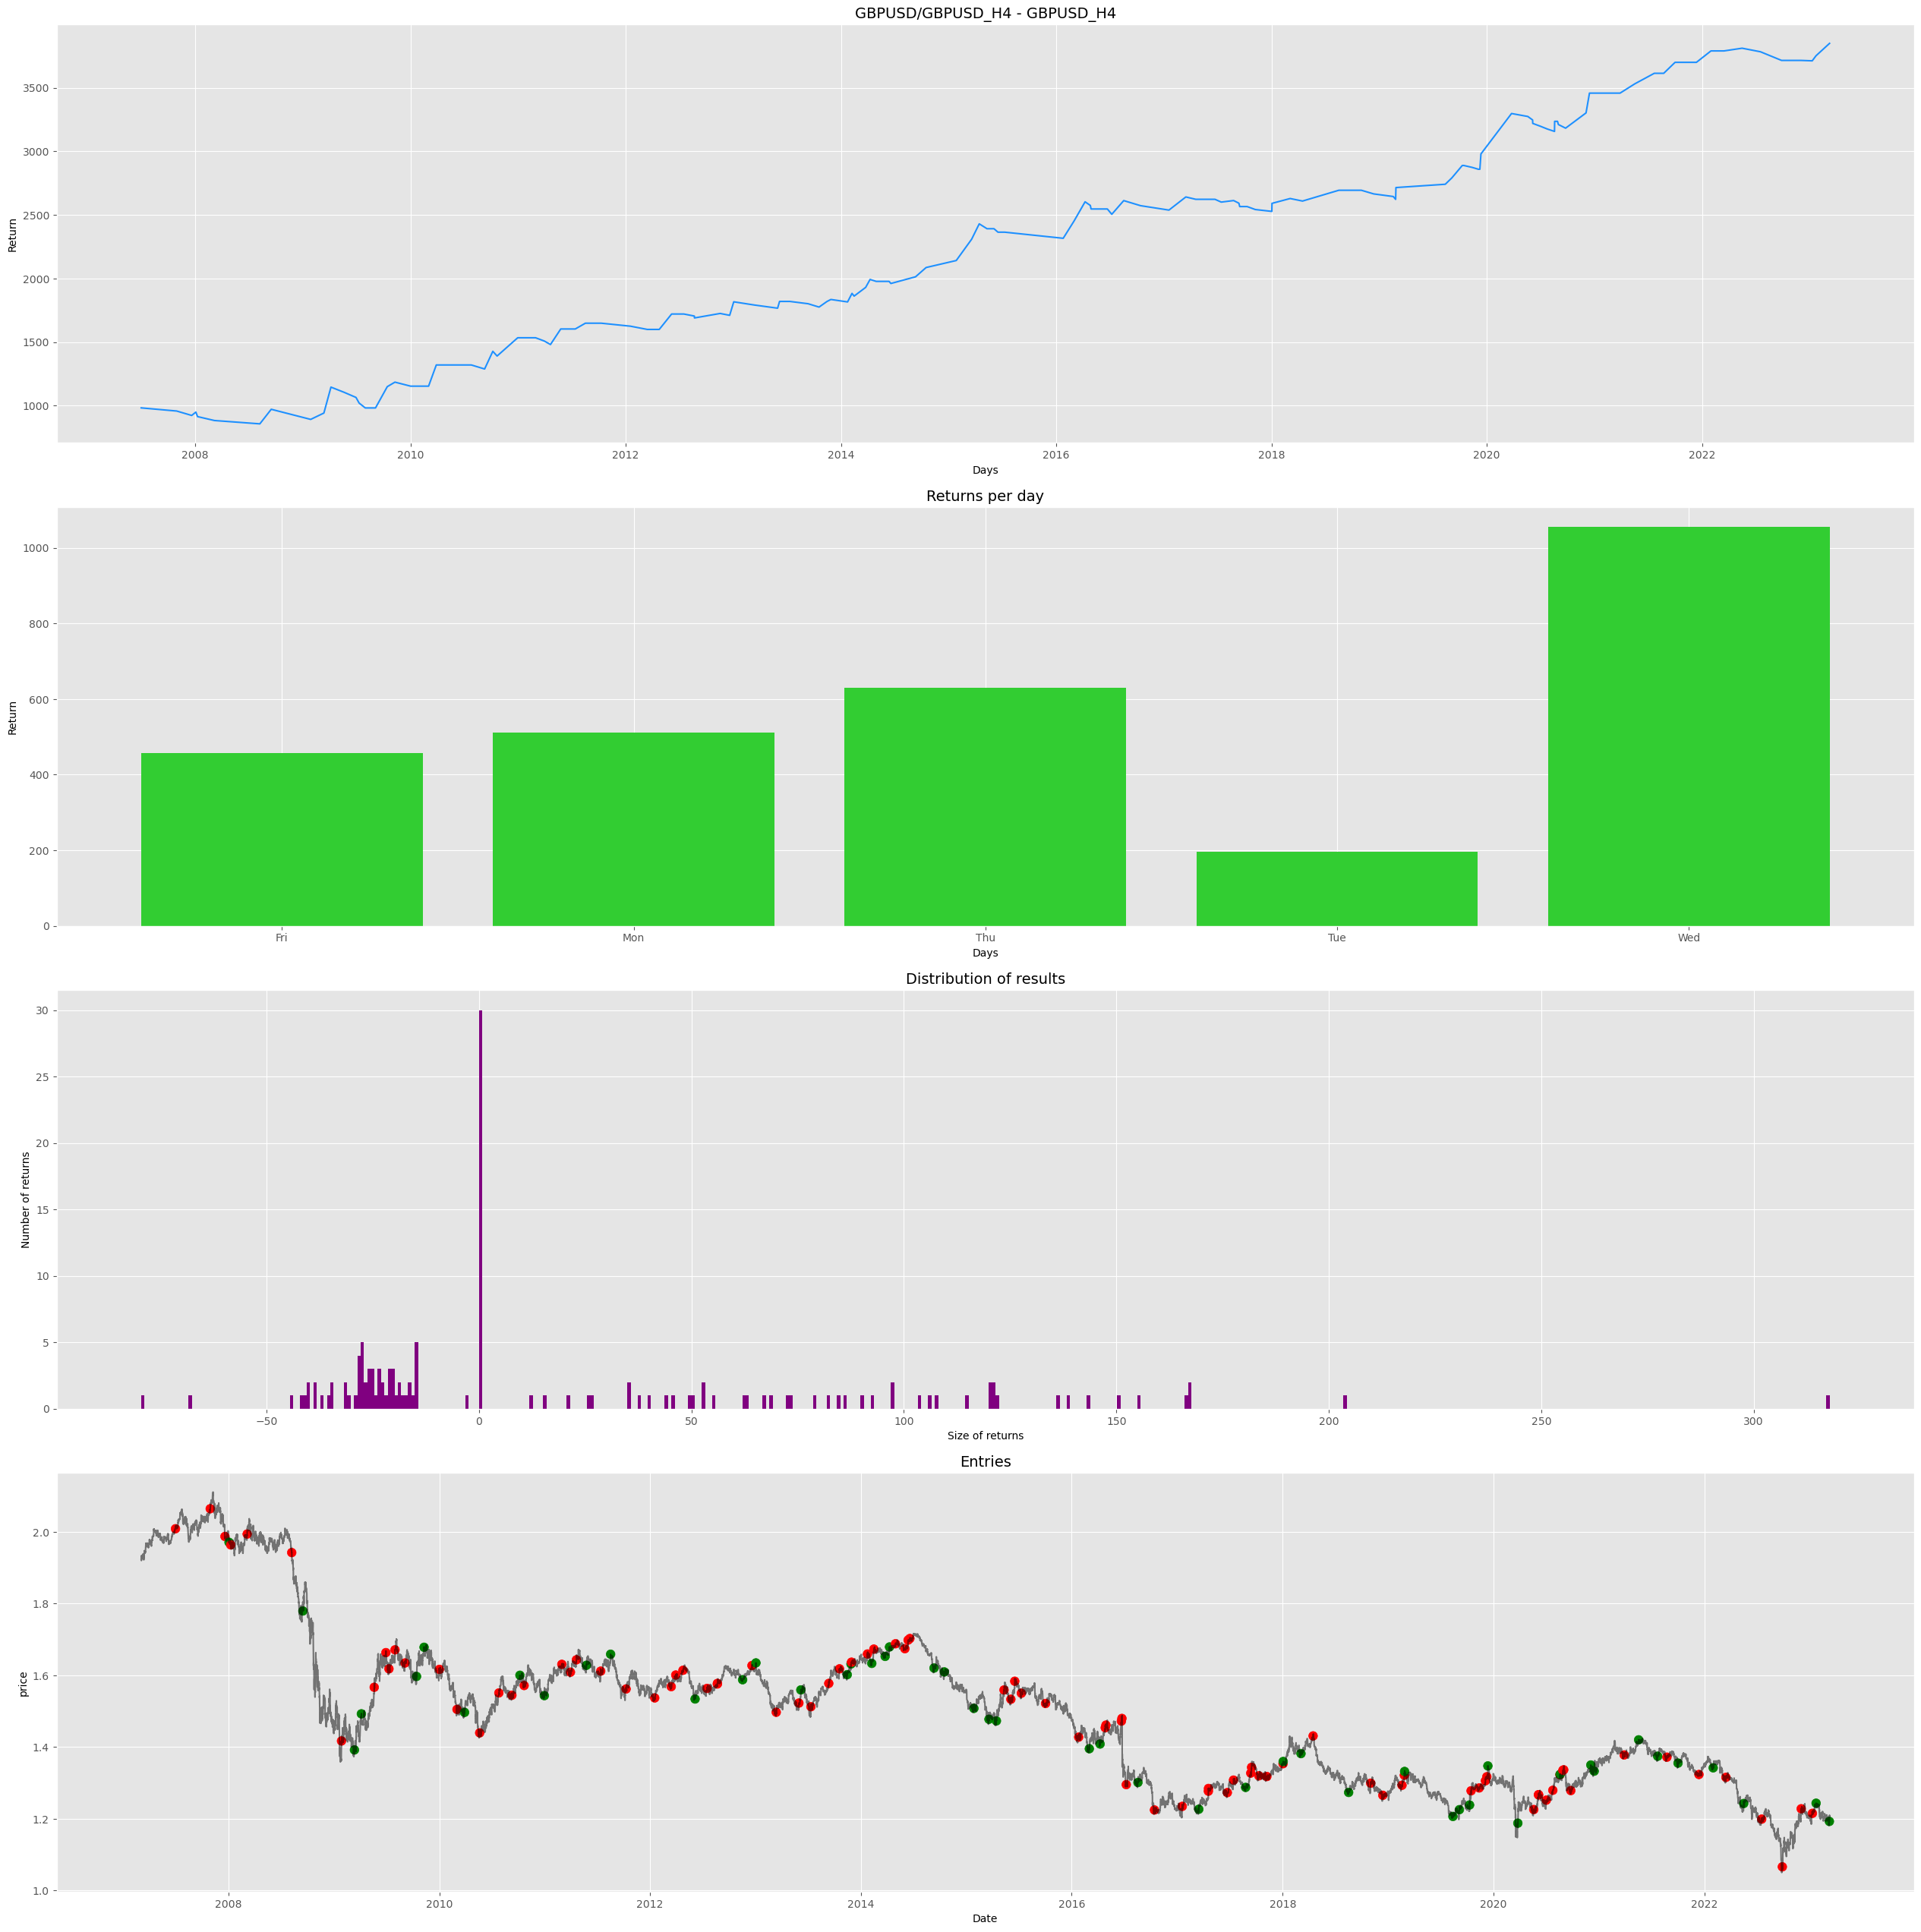

NZDUSD/NZDUSD_H4 - NZDUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 162
Number of profits: 42
Number of losses: 86
Number of breakevens: 34 

Winning percentage 32.81 %
ROI: 252.02
--------------------------------
Average profitable trade: 43.89
Average lossing trade: -18.5
Max profitable trade: 101.19
Max lossing trade: -33.02
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    38
Mon    17
Sun     3
Thu    32
Tue    32
Wed    40
Name: result, dtype: int64


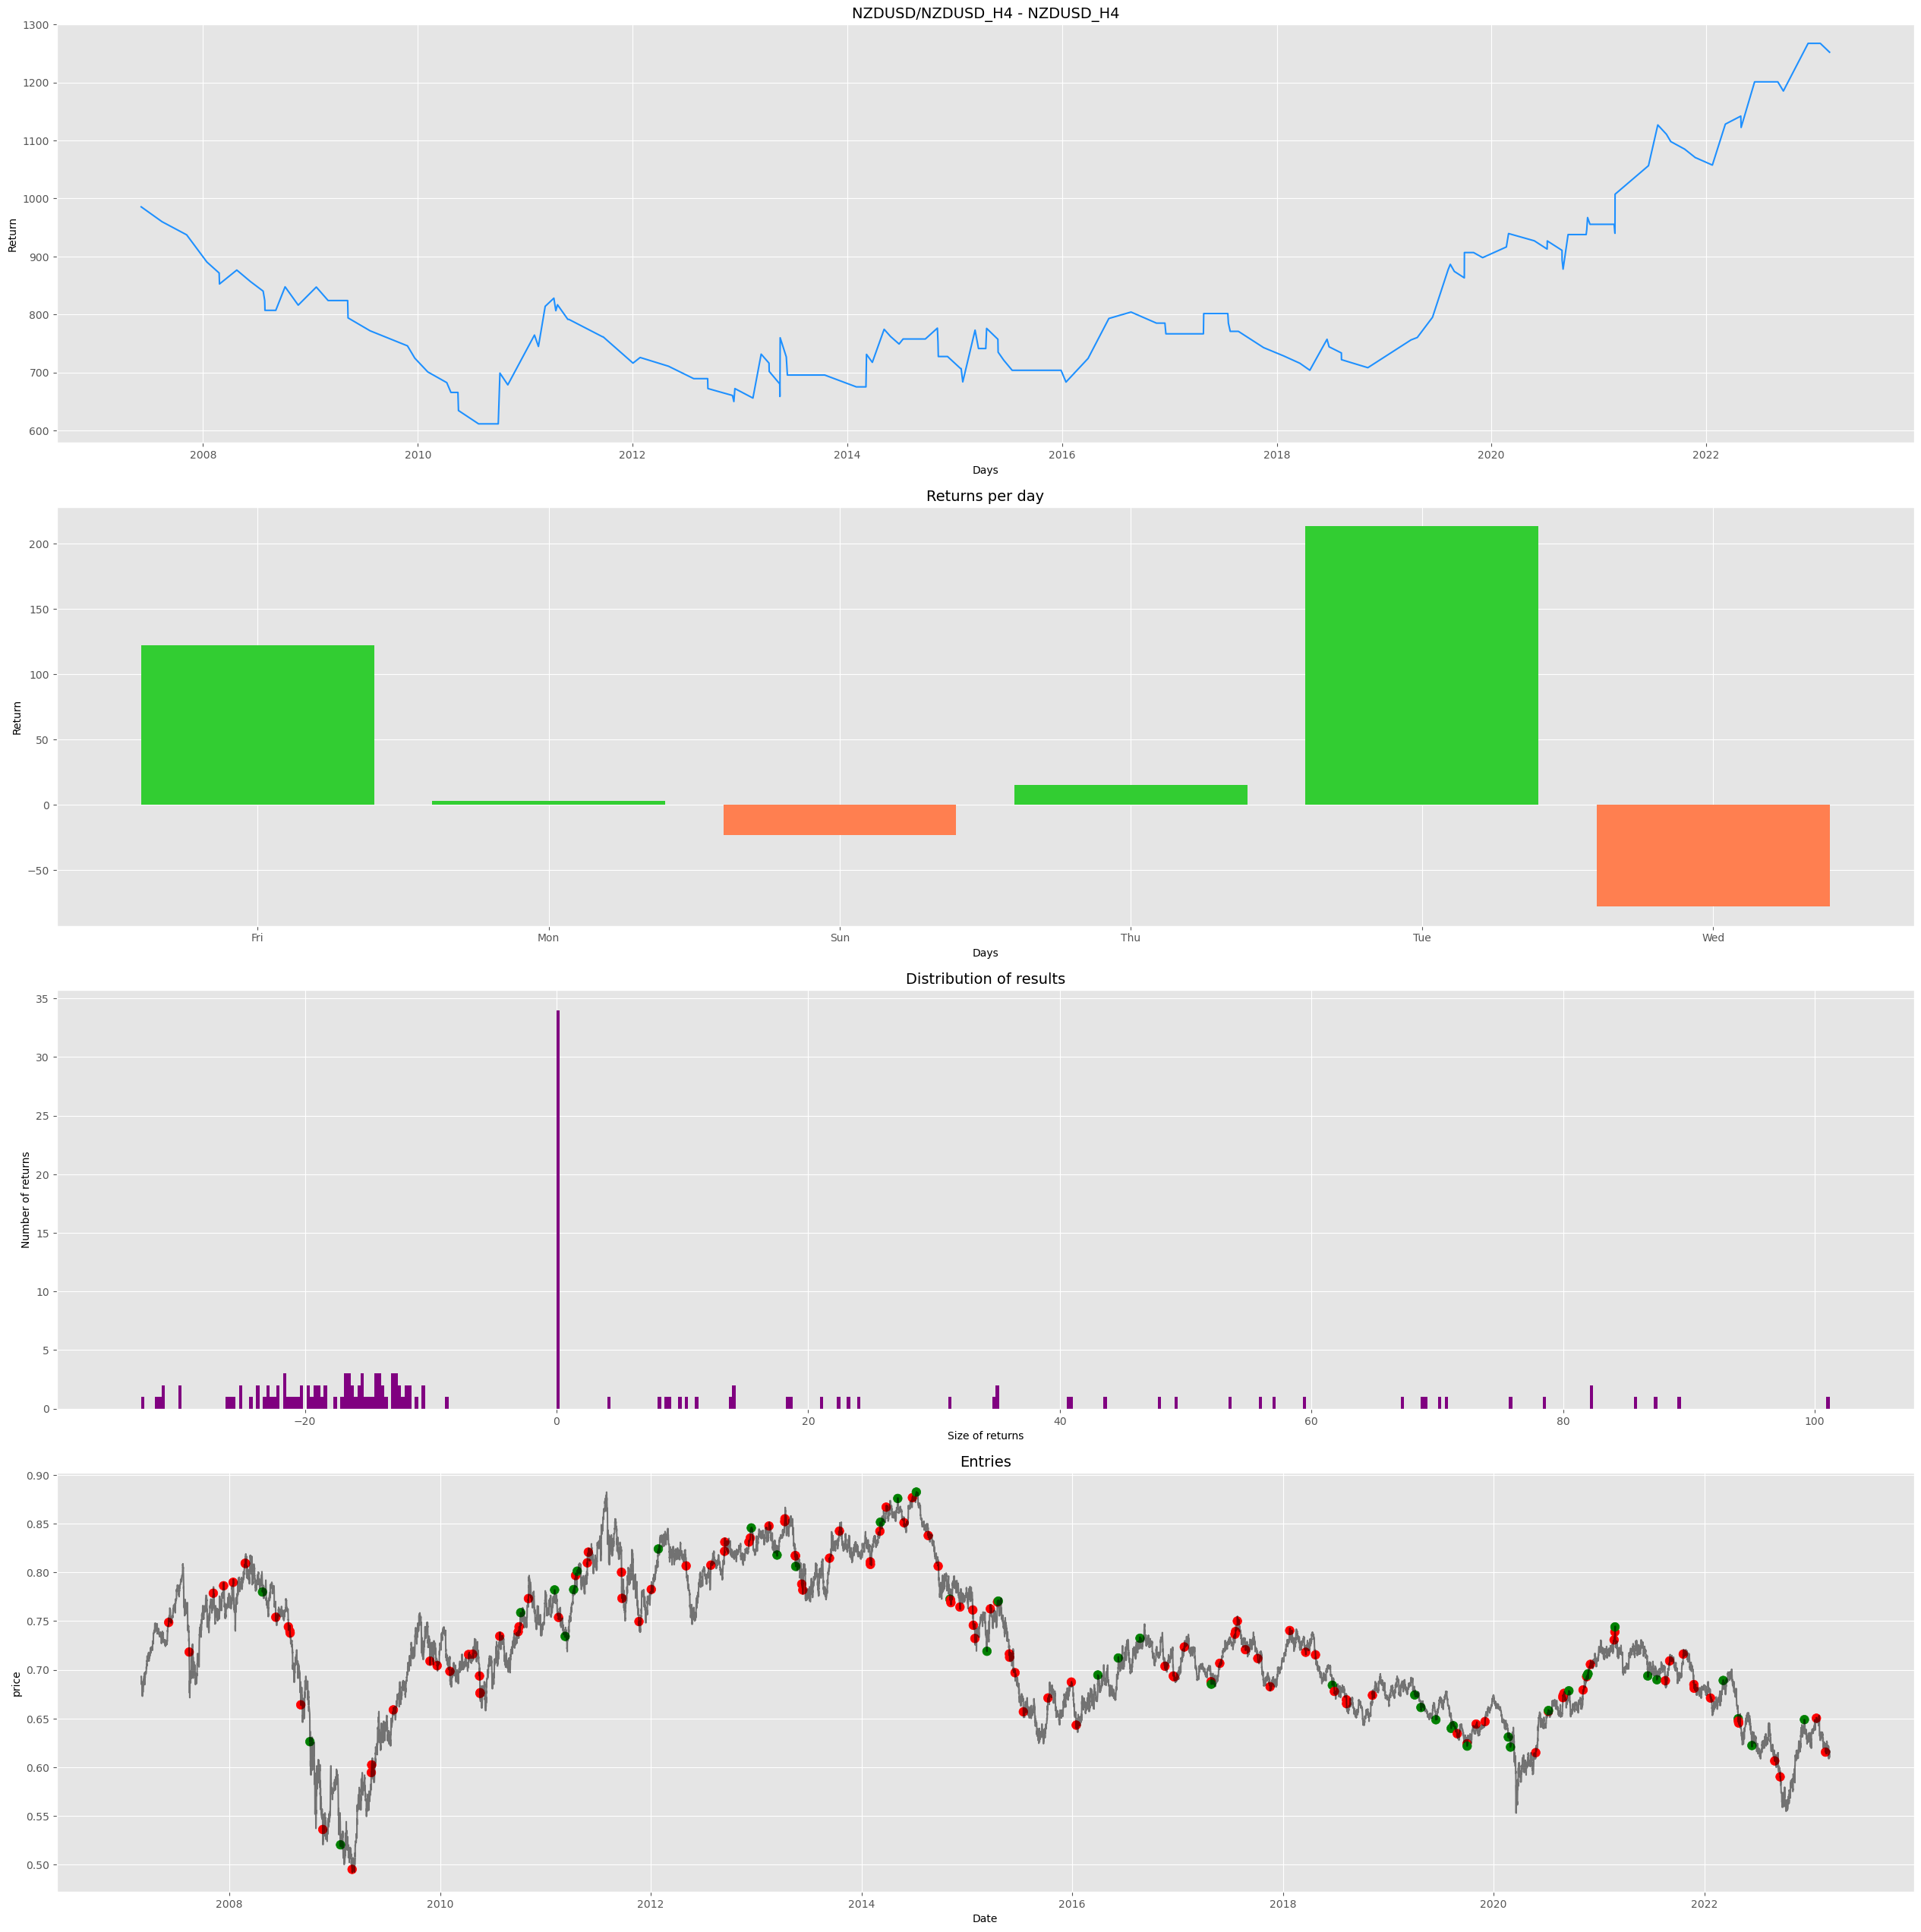

USDCAD/USDCAD_H4 - USDCAD_H4 - PERFORMANCE
--------------------------------
Number of trades: 137
Number of profits: 42
Number of losses: 79
Number of breakevens: 16 

Winning percentage 34.71 %
ROI: 1361.63
--------------------------------
Average profitable trade: 68.17
Average lossing trade: -19.0
Max profitable trade: 280.08
Max lossing trade: -44.27
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    21
Mon    26
Sun     4
Thu    24
Tue    25
Wed    37
Name: result, dtype: int64


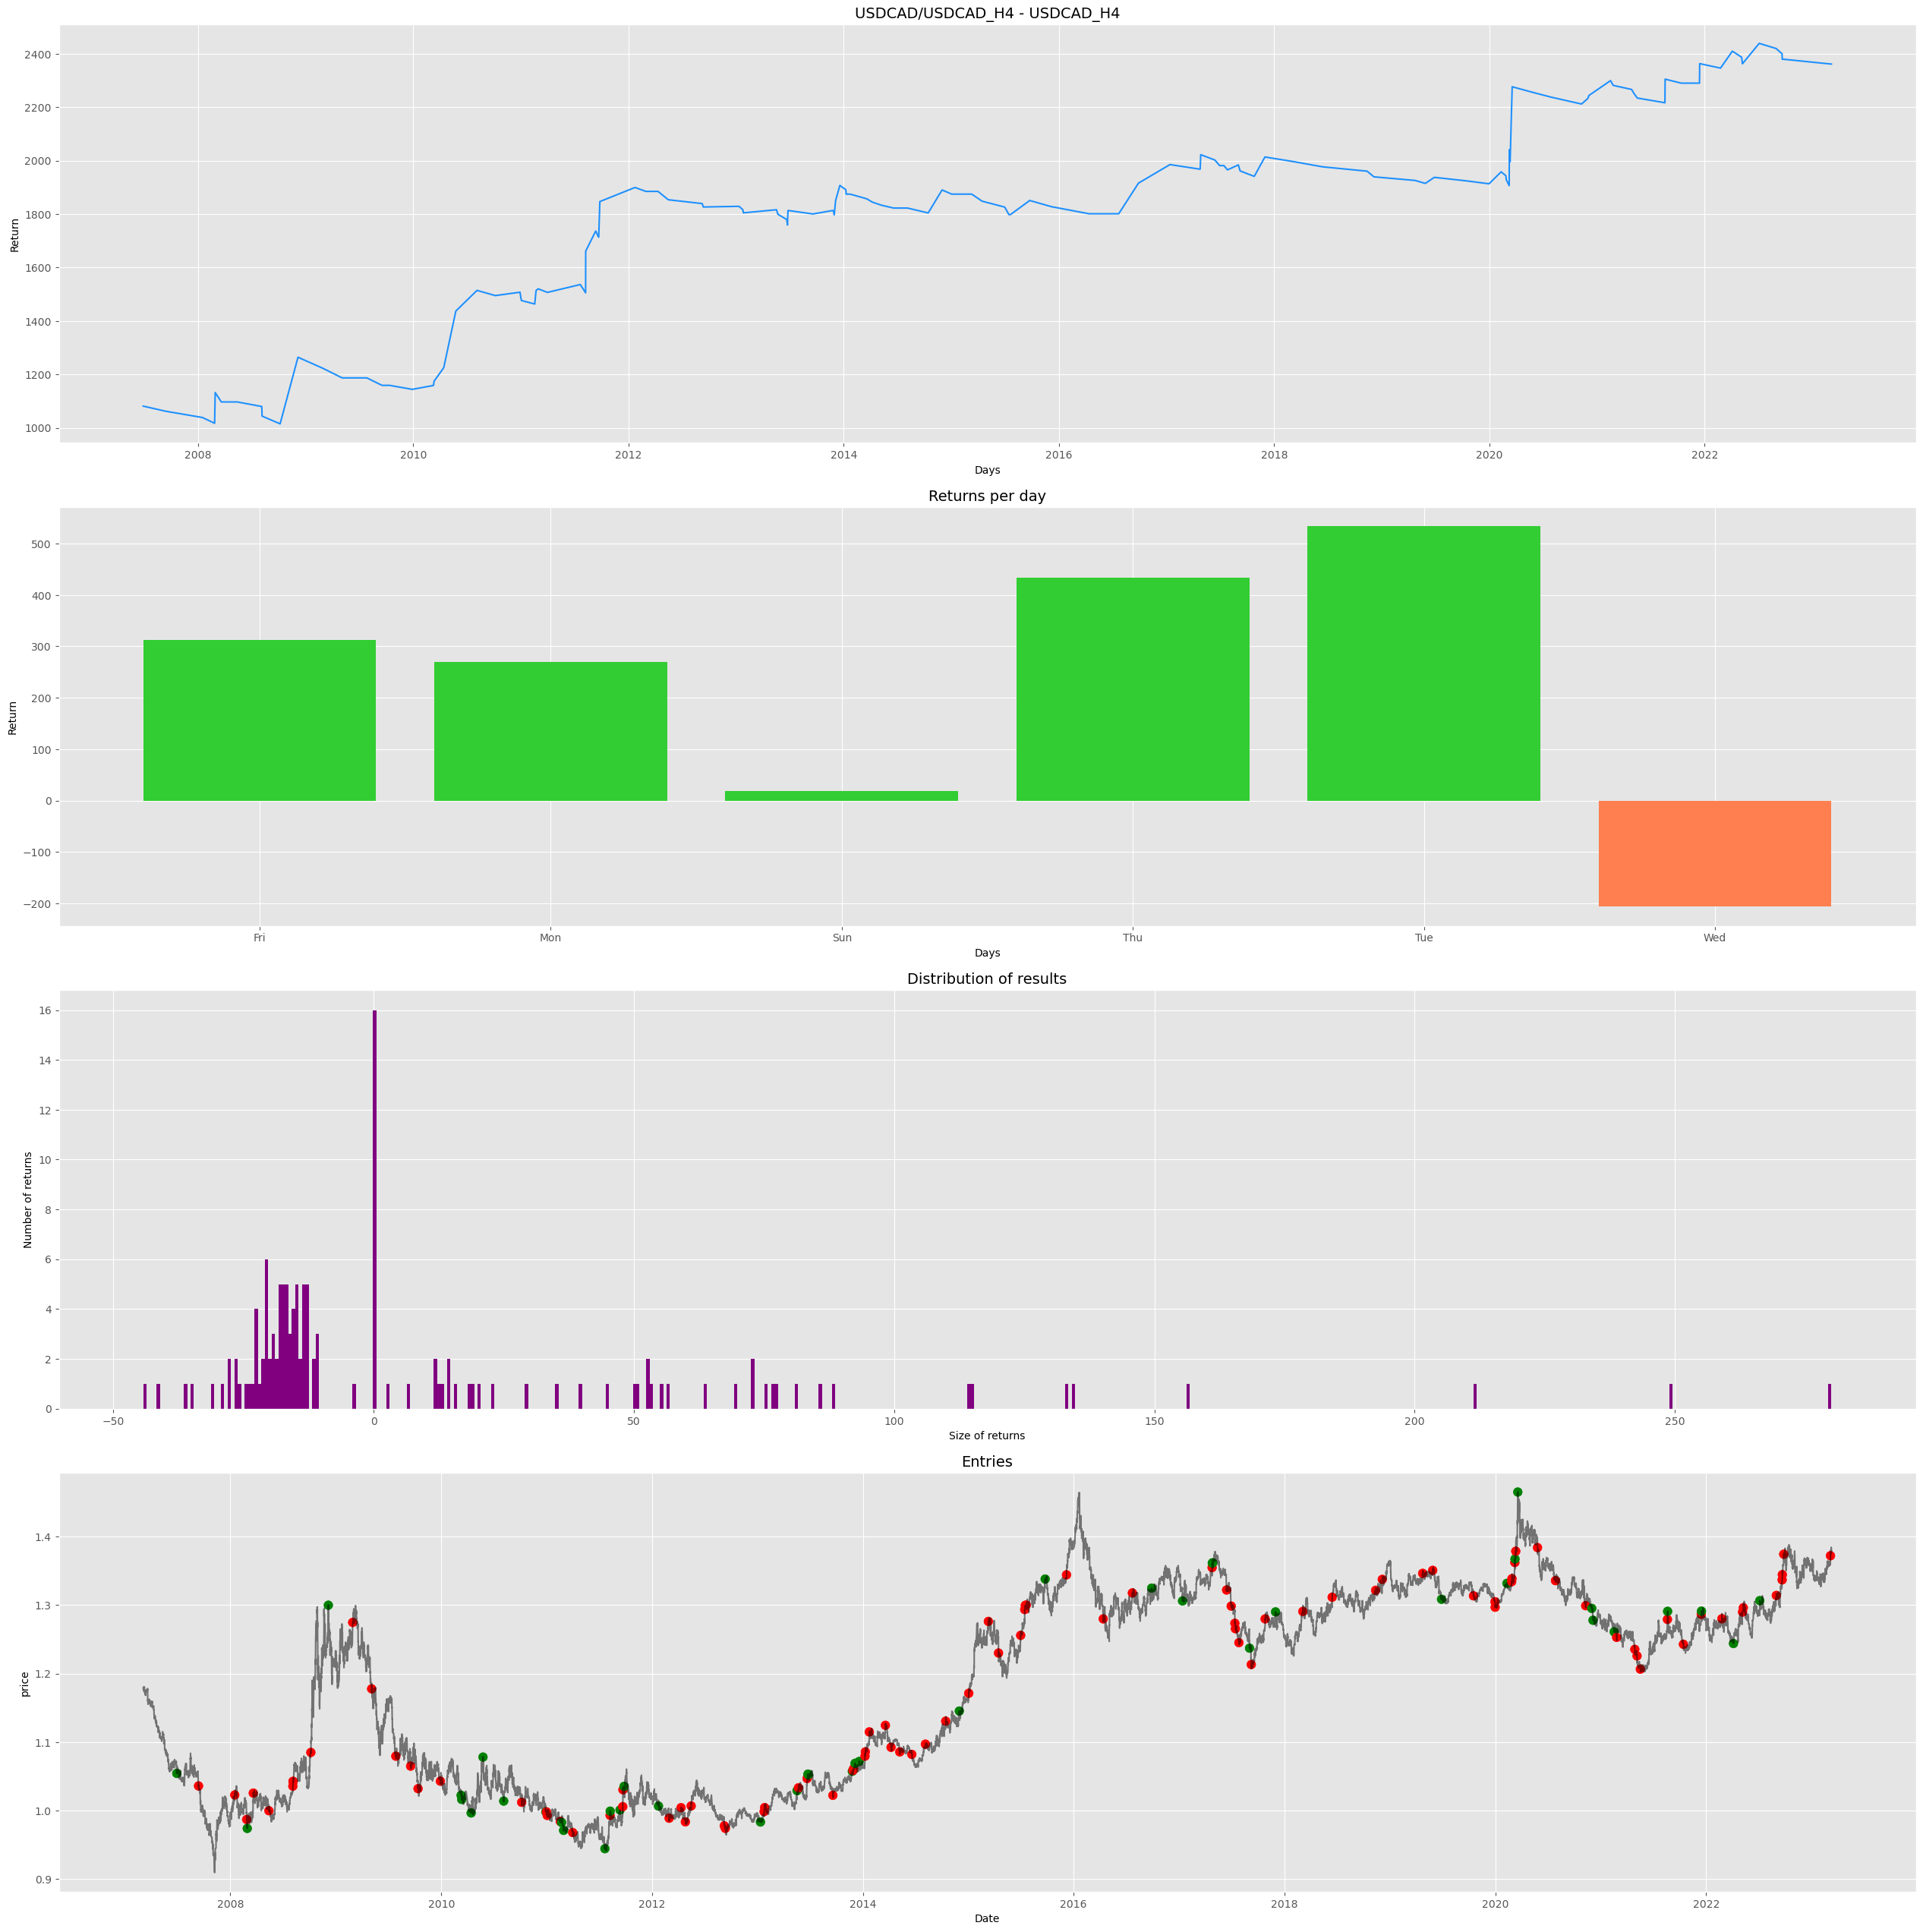

USDCHF/USDCHF_H4 - USDCHF_H4 - PERFORMANCE
--------------------------------
Number of trades: 154
Number of profits: 58
Number of losses: 68
Number of breakevens: 28 

Winning percentage 46.03 %
ROI: 2888.12
--------------------------------
Average profitable trade: 71.31
Average lossing trade: -18.35
Max profitable trade: 298.99
Max lossing trade: -71.41
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    29
Mon    19
Sun     3
Thu    35
Tue    33
Wed    35
Name: result, dtype: int64


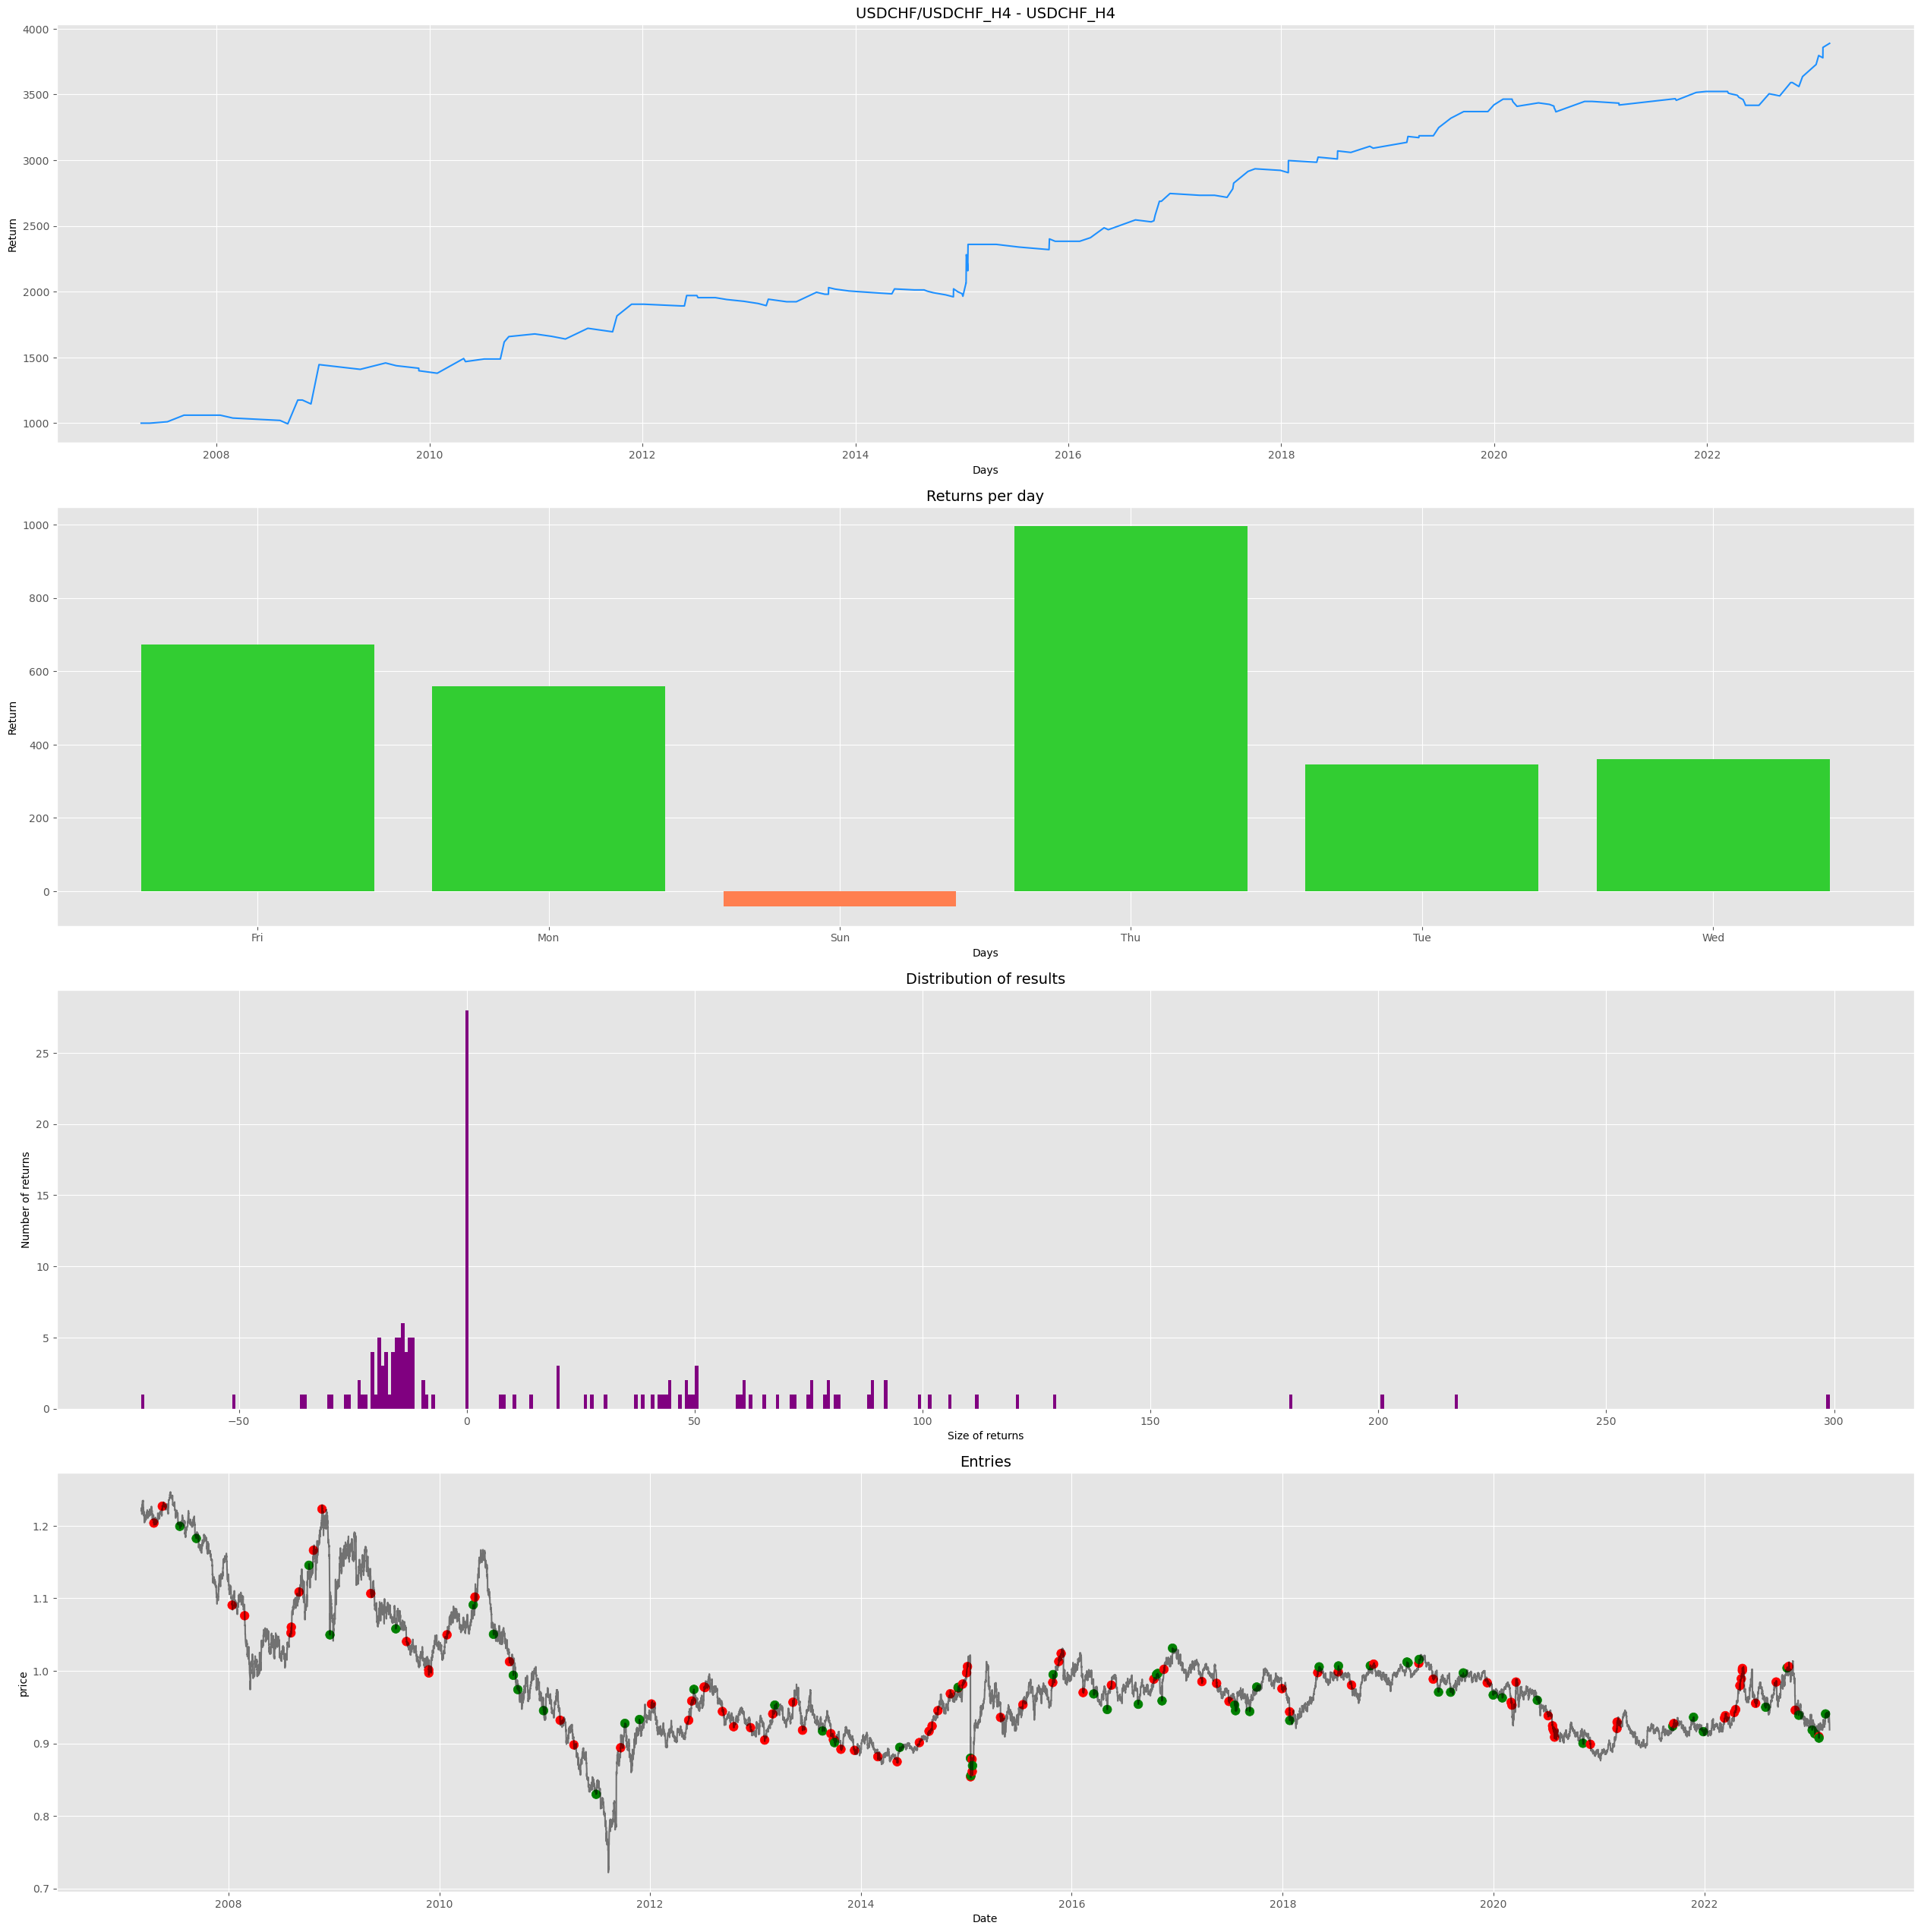

USDJPY/USDJPY_H4 - USDJPY_H4 - PERFORMANCE
--------------------------------
Number of trades: 144
Number of profits: 40
Number of losses: 79
Number of breakevens: 25 

Winning percentage 33.61 %
ROI: 712.83
--------------------------------
Average profitable trade: 57.34
Average lossing trade: -20.01
Max profitable trade: 243.9
Max lossing trade: -52.29
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    24
Mon    25
Sun     7
Thu    34
Tue    19
Wed    35
Name: result, dtype: int64


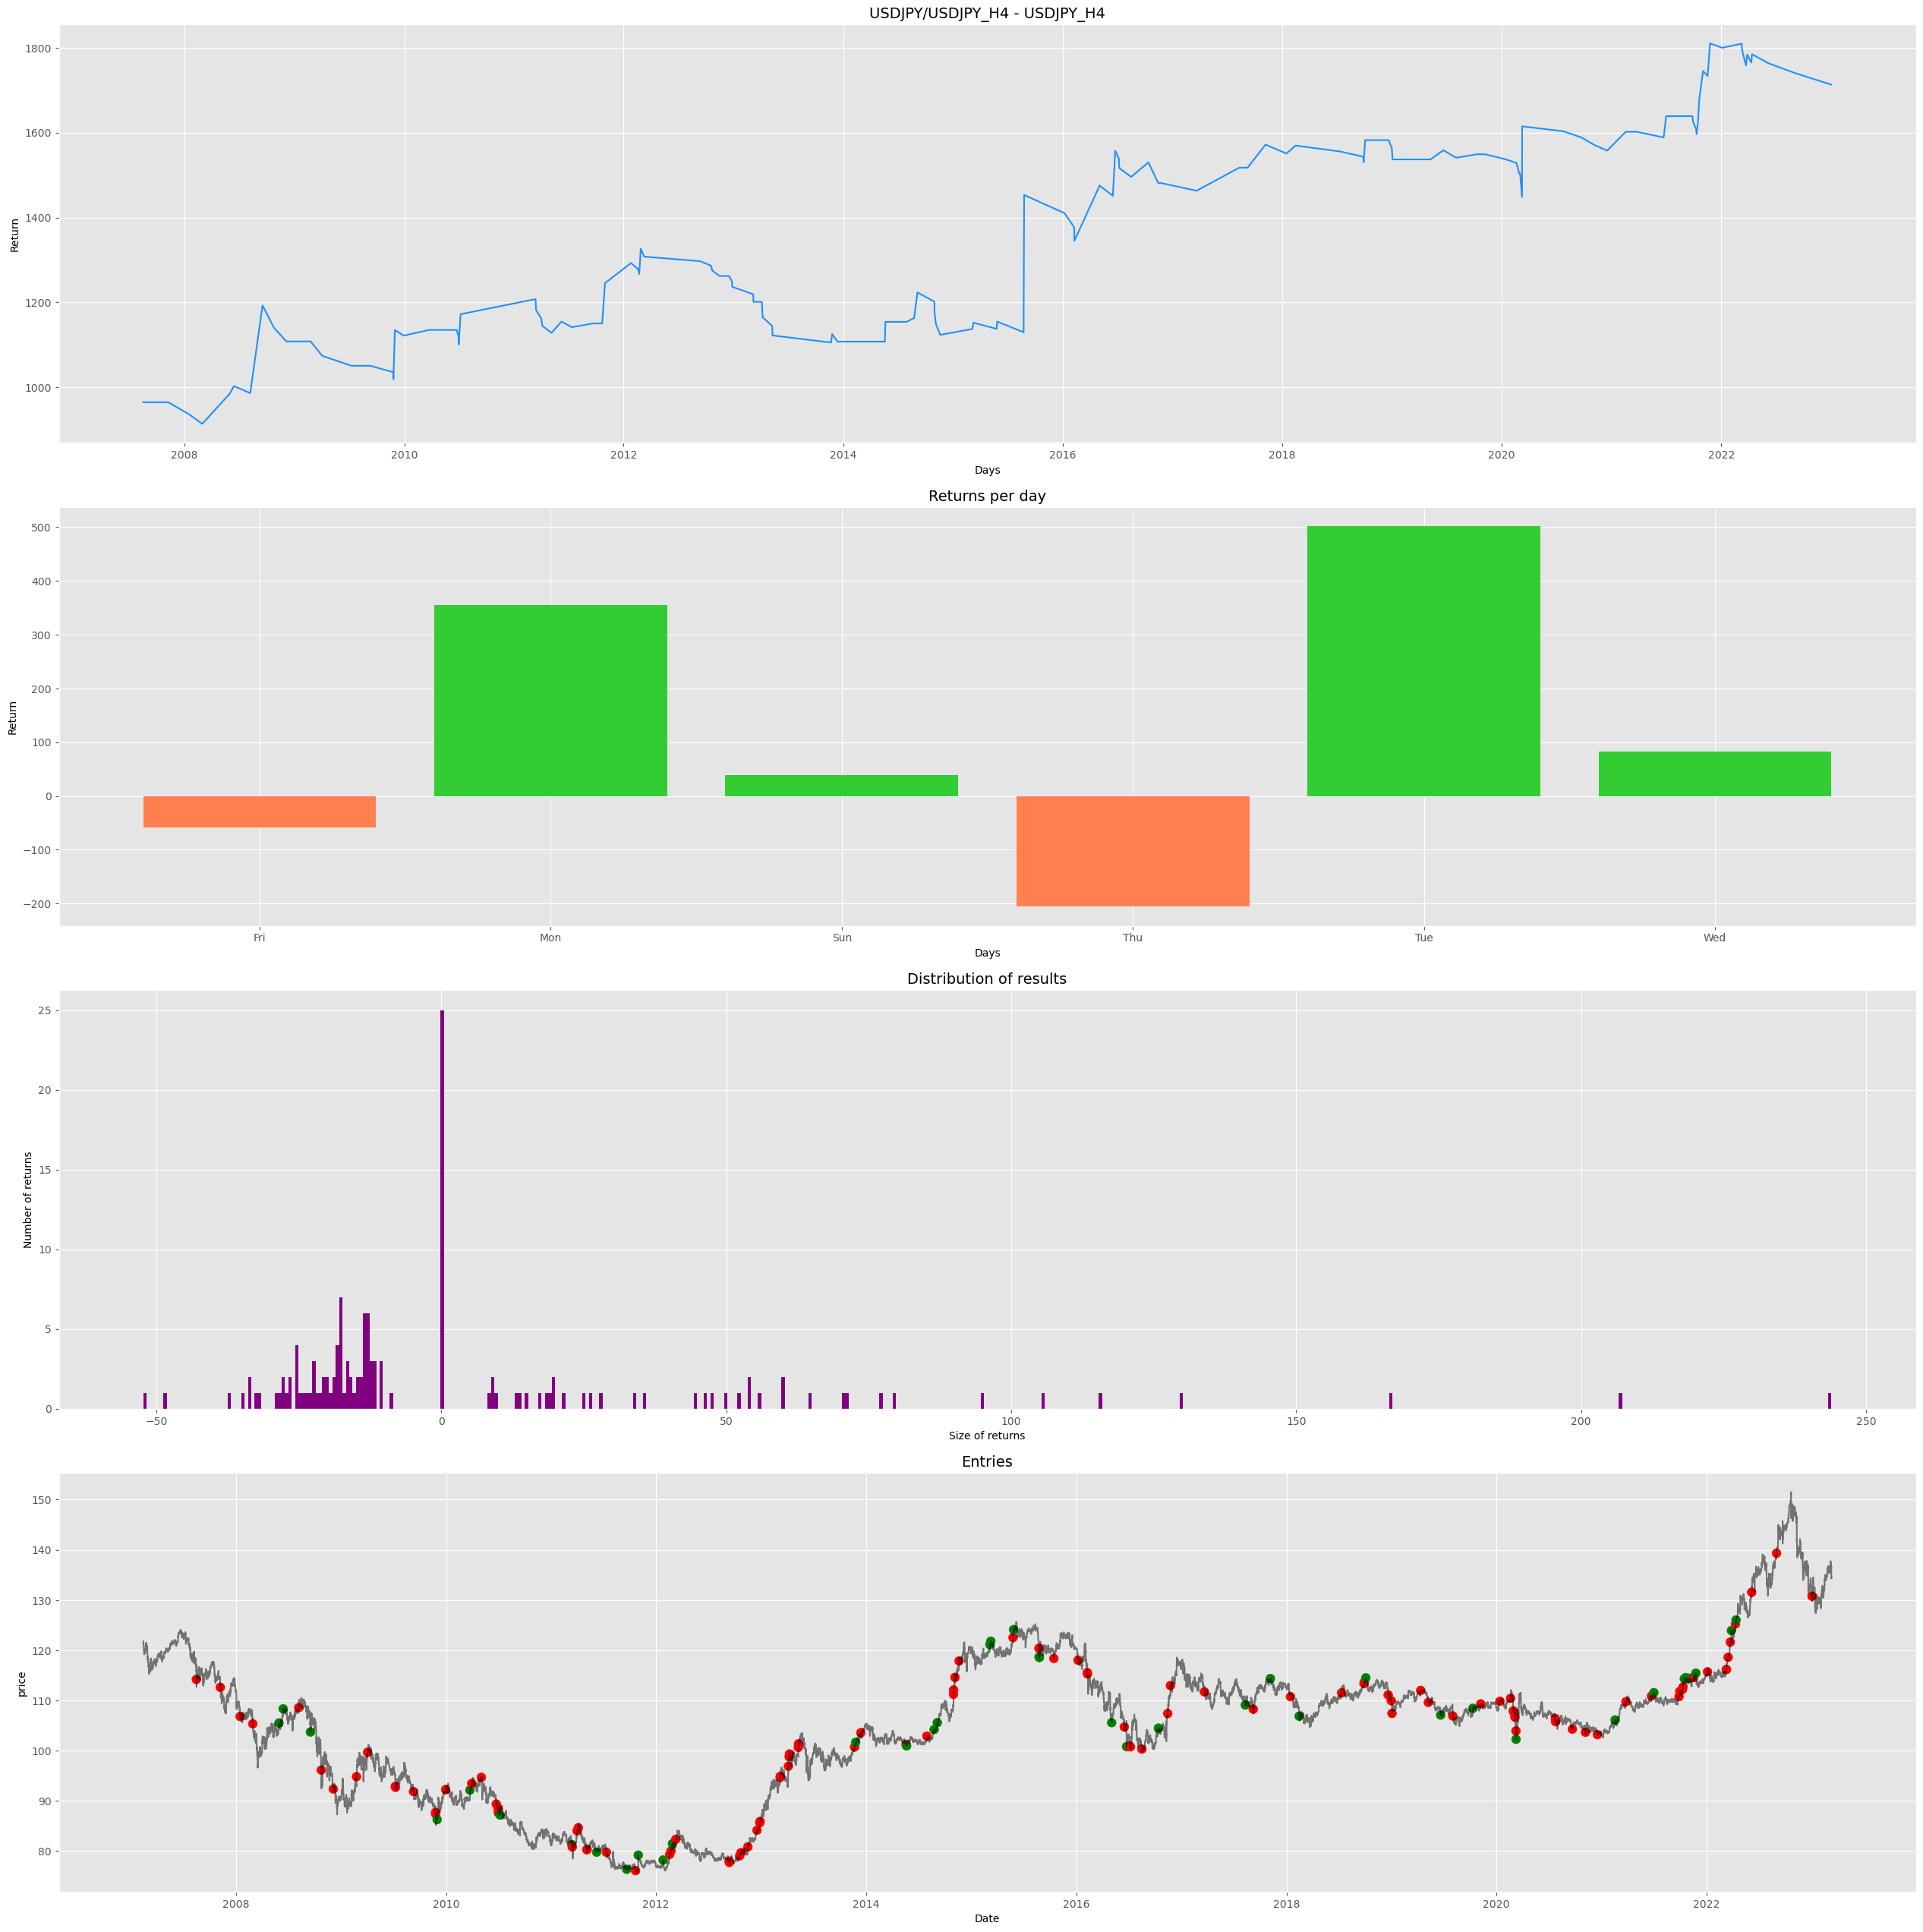

XAUUSD/XAUUSD_H4 - XAUUSD_H4 - PERFORMANCE
--------------------------------
Number of trades: 139
Number of profits: 61
Number of losses: 52
Number of breakevens: 26 

Winning percentage 53.98 %
ROI: 7185616.5
--------------------------------
Average profitable trade: 155504.61
Average lossing trade: -44233.93
Max profitable trade: 387598.0
Max lossing trade: -106929.0
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    36
Mon    20
Sun     3
Thu    25
Tue    28
Wed    27
Name: result, dtype: int64


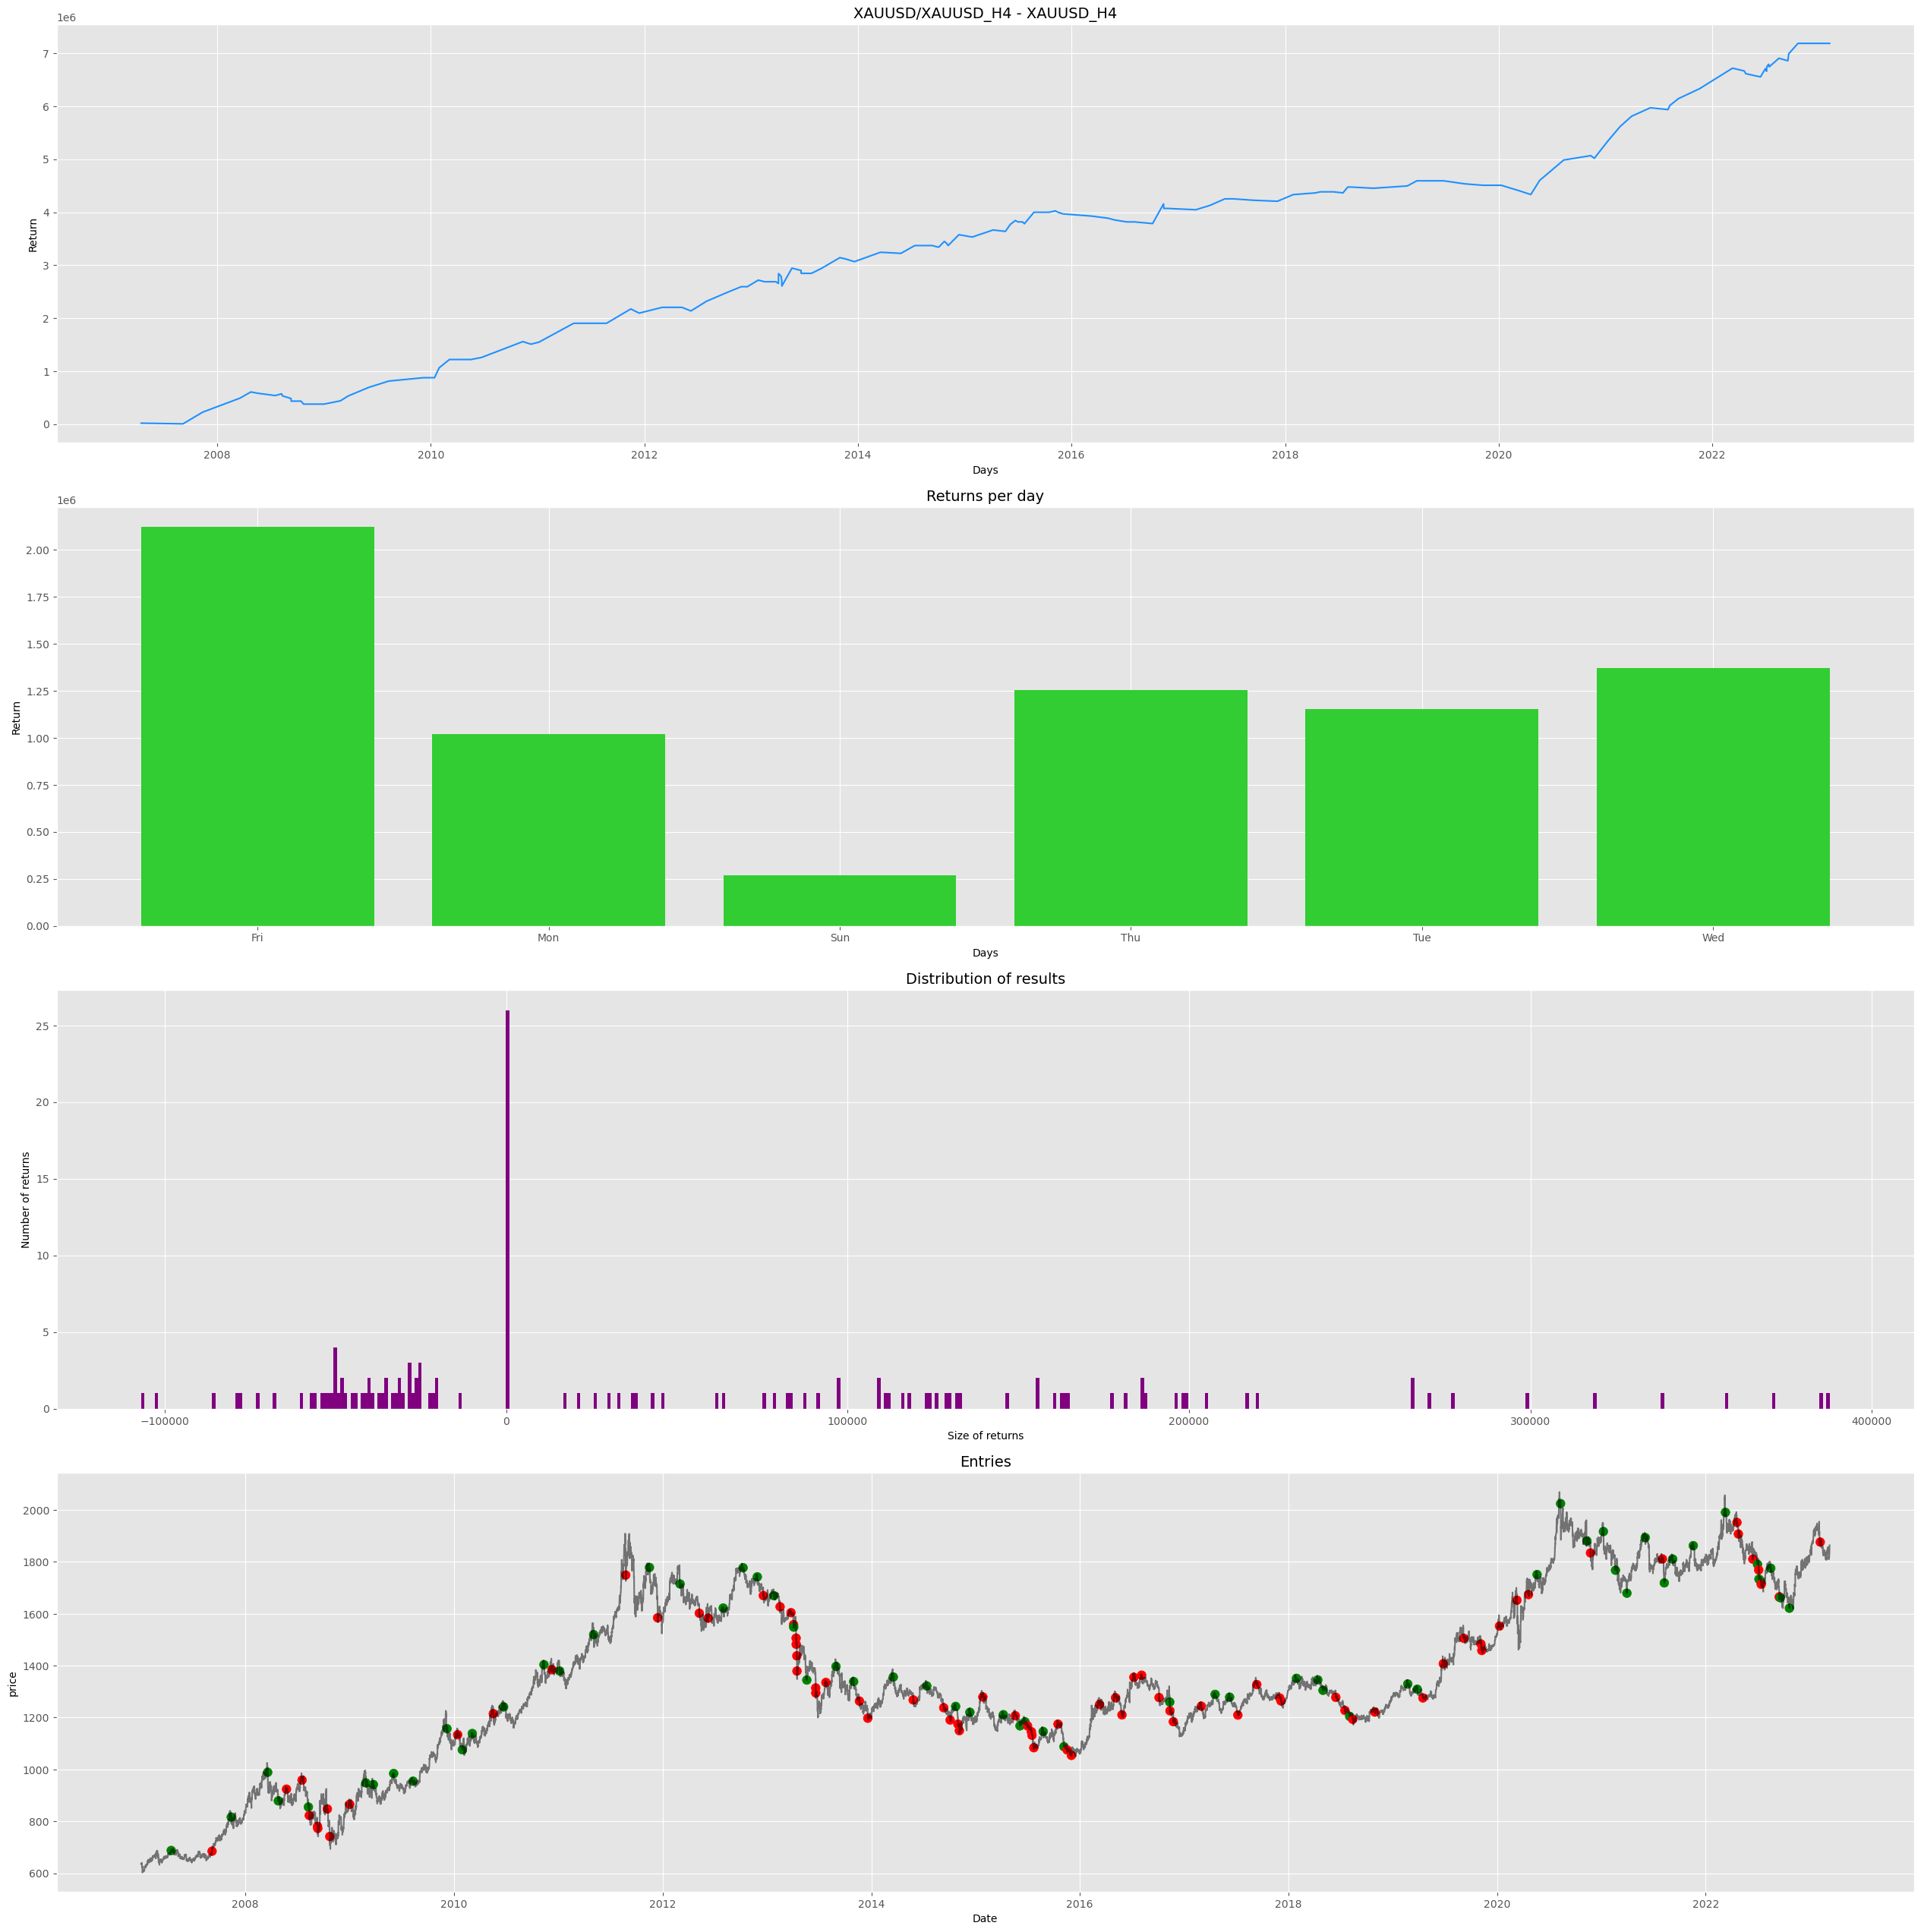

In [116]:
#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    print('Number of profits:', len(profits[pair]))
    print('Number of losses:', len(losses[pair]))
    print('Number of breakevens:', len(be[pair]), '\n')
    print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    print('--------------------------------')
    print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    print('Max profitable trade:', round(max(profits[pair]), 2))
    print('Max lossing trade:', round(min(losses[pair]), 2))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')
    
    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0
    
    print('Number of trades per day \n', trades_per_day)
    
    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)
    
    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')
    
    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')
    
    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')
    
    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')
    
    plt.show()